### Imports

In [3]:
!pip install pingouin
!pip install pycirclize

In [4]:
import pandas as pd
import re
import warnings
from collections import defaultdict
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pycirclize

In [5]:
from pandas.errors import PerformanceWarning
from pingouin import multivariate_normality
from sklearn.preprocessing import StandardScaler
from scipy.stats import t as t_dist
from statsmodels.stats.multitest import multipletests
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pycirclize import Circos

In [6]:
warnings.filterwarnings("ignore", category=PerformanceWarning)

In [7]:
pd.set_option("Display.max_rows", None)
pd.set_option("Display.max_columns", None)

### Initializing the Dataset

In [9]:
df = pd.read_excel("2020_master_data_merged.xlsx")

In [10]:
df.head()

RID  diagnosis  Sex   Age  EDUC  MMSE  MRI_Field_Strength  site   TIV  \
0   21          1    1  77.7    18    29                 3.0    11  1281   
1   23          1    0  77.0    14    26                 3.0    11  1370   
2   31          1    1  83.0    18    30                 1.5    23  1257   
3   42          4    0  78.0    18    23                 1.5    23  1411   
4   47          1    0  90.0    20    30                 1.5   100  1516   

   FDG.pons  AV45.whole.cerebellum  APOE4  SUMMARYSUVR_WHOLECEREBNORM  \
0  0.773000               1.139200    0.0                      1.0020   
1  0.788999               1.088983    0.0                      1.1242   
2  0.907775               1.086025    0.0                      1.2142   
3  0.979412               0.915848    0.0                      1.0009   
4  0.840300               0.996673    0.0                      1.0034   

   SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF Amy_Stage  LDELTOTAL  BNTSPONT  \
0                                    0.0         0       11.0      30.0   
1                                    1.0         0       26.0      27.0   
2                                    1.0         2       30.0      30.0   
3                                    0.0         0        0.0      27.0   
4                                    0.0         0       12.0      28.0   

   BNTTOTAL  TRAASCOR  TRABSCOR  TRAB-A  AVDEL30MIN  AVDELTOT  LIMMTOTAL  \
0      30.0      33.0      55.0    22.0        12.0      15.0       14.0   
1      27.0      40.0      76.0    36.0         4.0      14.0       13.0   
2      30.0      44.0      64.0    20.0         7.0      14.0       21.0   
3      27.0      51.0     115.0    64.0         0.0       0.0        6.0   
4      29.0      38.0     101.0    63.0         6.0      12.0       15.0   

   CDR (CDGLOBAL) at scan ADNI_MEM ADNI_EF  T1_year  ABETA   TAU  PTAU  \
0                     NaN    1.691   1.132     2010    NaN   NaN   NaN   
1                     0.0    0.757   -0.05     2010    NaN   NaN   NaN   
2                     0.0    1.462   0.266     2010  133.0  44.9  91.2   
3                     1.0   -1.208  -0.105     2011  241.0  60.2  44.3   
4                     0.0    0.659   0.535     2011    NaN   NaN   NaN   

   Abeta_pos  GM_Frontal_Pole_L  GM_Insular_Cortex_L  \
0        NaN       17698.000000          5820.000000   
1        NaN       16964.671157          5221.919467   
2        1.0       15855.315837          4855.598166   
3        0.0       13162.290906          4103.568322   
4        NaN       14217.345480          4482.573677   

   GM_Superior_Frontal_Gyrus_L  GM_Middle_Frontal_Gyrus_L  \
0                  7276.000000                6063.000000   
1                  7461.012046                5888.729270   
2                  7267.788499                6072.514356   
3                  7285.517251                6115.024305   
4                  6127.950721                6439.188588   

   GM_Inferior_Frontal_Gyrus_pars_triangularis_L  \
0                                    1387.000000   
1                                    1685.568444   
2                                    1458.120591   
3                                    1361.979414   
4                                    1051.580412   

   GM_Inferior_Frontal_Gyrus_pars_opercularis_L  GM_Precentral_Gyrus_L  \
0                                   1924.000000            7474.000000   
1                                   2351.473171            8128.741372   
2                                   1665.946440            7769.539236   
3                                   1504.329323            7153.260165   
4                                   1161.299941            6020.075421   

   GM_Temporal_Pole_L  GM_Superior_Temporal_Gyrus_anterior_L  \
0         6642.000000                             982.000000   
1         7359.774743                             830.559085   
2         6844.941639                             845.107453   
3         5189.897652               

In [11]:
# diagnosis_map = {
#     1: 'CN',      # Cognitively Normal
#     2: 'EMCI',    # Early Mild Cognitive Impairment
#     3: 'LMCI',    # Late Mild Cognitive Impairment
#     4: 'AD',      # Alzheimer’s Disease
#     5: 'SMC'      # Subjective Memory Complaints
# }

# df['Diagnosis_Group'] = df['diagnosis'].map(diagnosis_map)

# df['Sex'] = df['Sex'].astype(int)

# summary_df = df.groupby('Diagnosis_Group').agg(
#     Sample_size=('RID', 'count'),
#     Female_pct=('Sex', lambda x: round((x == 0).mean() * 100)),
#     Age_mean_sd=('Age', lambda x: f"{x.mean():.1f} ({x.std():.1f})"),
#     Educ_mean_sd=('EDUC', lambda x: f"{x.mean():.1f} ({x.std():.1f})")
# ).reset_index()

# desired_order = ['CN', 'EMCI', 'LMCI', 'AD', 'SMC']
# summary_df = summary_df.set_index('Diagnosis_Group').loc[desired_order].reset_index()

# transposed_df = summary_df.set_index('Diagnosis_Group').T

In [12]:
# transposed_df.head()

In [13]:
df.describe()

RID    diagnosis          Sex          Age         EDUC  \
count  1075.000000  1075.000000  1075.000000  1075.000000  1075.000000   
mean   3723.506047     2.607442     0.464186    73.677023    16.209302   
std    1602.372231     1.280254     0.498948     7.508754     2.687981   
min      21.000000     1.000000     0.000000    55.000000     6.000000   
25%    2302.500000     2.000000     0.000000    68.000000    14.000000   
50%    4383.000000     2.000000     0.000000    74.000000    16.000000   
75%    4842.500000     4.000000     1.000000    79.000000    18.000000   
max    6427.000000     5.000000     1.000000    93.000000    20.000000   

              MMSE  MRI_Field_Strength         site          TIV     FDG.pons  \
count  1075.000000         1075.000000  1075.000000  1075.000000  1075.000000   
mean     27.405581            2.783721    76.320930  1402.332093     0.819964   
std       3.002973            0.527163   117.010625   137.863737     0.070635   
min       7.000000            1.500000     2.000000  1067.000000     0.587000   
25%      26.000000            3.000000    21.000000  1299.000000     0.771732   
50%      28.000000            3.000000    52.000000  1396.000000     0.815000   
75%      30.000000            3.000000   116.000000  1498.000000     0.866000   
max      30.000000            3.000000   941.000000  1857.000000     1.137087   

       AV45.whole.cerebellum        APOE4  SUMMARYSUVR_WHOLECEREBNORM  \
count            1075.000000  1045.000000                 1074.000000   
mean                1.101828     0.520574                    1.200100   
std                 0.071884     0.645354                    0.229072   
min                 0.896325     0.000000                    0.805400   
25%                 1.053235     0.000000                    1.006925   
50%                 1.097946     0.000000                    1.124450   
75%                 1.149756     1.000000                    1.377225   
max                 1.409000     2.000000                    2.006000   

       SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF    LDELTOTAL     BNTSPONT  \
count                            1074.000000  1054.000000  1052.000000   
mean                                0.522346     8.407021    26.266160   
std                                 0.499733     5.405002     4.236298   
min                                 0.000000     0.000000     1.000000   
25%                                 0.000000     4.000000    25.000000   
50%                                 1.000000     9.000000    28.000000   
75%                                 1.000000    12.000000    29.000000   
max                                 1.000000    30.000000    30.000000   

          BNTTOTAL    TRAASCOR     TRABSCOR       TRAB-A   AVDEL30MIN  \
count  1051.000000  1067.00000  1036.000000  1035.000000  1065.000000   
mean     26.527117    41.24836   111.216216    71.378744     4.946479   
std       4.348834    22.53351    69.056426    57.863054     4.446418   
min       0.000000    13.00000    32.000000     0.000000     0.000000   
25%      25.000000    28.00000    65.000000    34.000000     1.000000   
50%      28.000000    35.00000    87.000000    50.000000     4.000000   
75%      29.000000    46.00000   126.000000    88.000000     8.000000   
max      30.000000   180.00000   301.000000   276.000000    15.000000   

          AVDELTOT   LIMMTOTAL  CDR (CDGLOBAL) at scan      T1_year  \
count  1065.000000  832.000000              408.000000  1075.000000   
mean     10.947418   10.301683                0.382353  2011.633488   
std       3.796399    4.863142                0.435955     1.148067   
min       0.000000    0.000000                0.000000  2009.000000   
25%       9.000000    7.000000                0.000000  2011.000000   
50%      12.000000   11.000000                0.500000  2012.000000   
75%      14.000000   14.000000                0.500000  2012.000000   
max      15.000000   24.000000                3.000000  2018.000000

In [14]:
df.shape

(1075, 356)

In [15]:
df_males = df[df["Sex"]==1]
df_females = df[df["Sex"] == 0]

In [16]:
print(df_males.shape)
df_females.shape

(499, 356)


(576, 356)

In [17]:
df_merged = df.copy()

lateral_columns = [col for col in df_merged.columns if re.search(r'(^.+_[LR]$)|(^.+_[LR]_.+)', col)]


hemisphere_pairs = defaultdict(dict)

for col in lateral_columns:

    match = re.match(r'(.+)_([LR])$', col)  
    if not match:
        match = re.match(r'(.+)_([LR])_(.+)', col)  
        if match:
            prefix, side, region = match.groups()
            base = f"{prefix}_{region}"
            hemisphere_pairs[base][side] = col
    else:
        base, side = match.groups()
        hemisphere_pairs[base][side] = col


for base, sides in hemisphere_pairs.items():
    if 'L' in sides and 'R' in sides:
        df_merged[base + '_avg'] = df_merged[[sides['L'], sides['R']]].mean(axis=1)
        df_merged.drop(columns=[sides['L'], sides['R']], inplace=True)

In [18]:
# for col in df_merged.columns:
#     print(col)
df_merged.shape

(1075, 194)

### Lucas Variable Set

In [20]:
#Set Of Variables Used By Lucas
var_set_L = [
    #Target Variable
    #"diagnosis",
    
    # Gray matter (GM) volumes
    'GM_Thalamus_avg',
    'GM_Cingulate_Gyrus_posterior_avg',  # PCC
    'GM_Precuneus_Cortex_avg',
    'GM_Hippocampus_avg',
    'GM_Caudate_avg',
    'GM_Putamen_avg',

    # Glucose metabolism (FDG)
    'FDGpvc_Thalamus_avg',
    'FDGpvc_Cingulate_Gyrus_posterior_avg',  # PCC
    'FDGpvc_Precuneus_Cortex_avg',
    'FDGpvc_Hippocampus_avg',
    'FDGpvc_Caudate_avg',
    'FDGpvc_Putamen_avg',

    # Demographics
    'Age',
    'Sex',
    'EDUC',

    # Genetics & Pathology
    'APOE4',
    'Amy_Stage',

    # Cognitive composite scores
    'ADNI_MEM',
    'ADNI_EF'
]

In [21]:
df_analysis_v1 = df_merged[var_set_L]

In [22]:
df_analysis_v1.head()

GM_Thalamus_avg  GM_Cingulate_Gyrus_posterior_avg  GM_Precuneus_Cortex_avg  \
0      2342.000000                       3833.000000              6666.500000   
1      2530.714997                       4534.833771              7653.521365   
2      2262.645334                       3842.660762              7301.953574   
3      1468.034161                       3682.533619              7469.767689   
4      1207.956392                       3495.144597              6656.866917   

   GM_Hippocampus_avg  GM_Caudate_avg  GM_Putamen_avg  FDGpvc_Thalamus_avg  \
0         3604.500000     2312.000000     2007.500000             1.300500   
1         3535.287428     1953.383860     1993.962494             1.294617   
2         3055.148350     3532.617875     2410.474786             1.387830   
3         1896.243864     2425.181330      609.844016             0.981553   
4         2848.326306     1511.087098      465.423504             0.646810   

   FDGpvc_Cingulate_Gyrus_posterior_avg  FDGpvc_Precuneus_Cortex_avg  \
0                              1.860500                     1.705500   
1                              1.451785                     1.399894   
2                              1.425141                     1.378256   
3                              1.196865                     1.357629   
4                              1.457936                     1.645238   

   FDGpvc_Hippocampus_avg  FDGpvc_Caudate_avg  FDGpvc_Putamen_avg   Age  Sex  \
0                1.752500            0.980000            1.558000  77.7    1   
1                0.905093            0.921287            1.641047  77.0    0   
2                0.943310            0.969983            1.430798  83.0    1   
3                0.704295            0.595724            0.320427  78.0    0   
4                0.767164            0.803841            0.699511  90.0    0   

   EDUC  APOE4 Amy_Stage ADNI_MEM ADNI_EF  
0    18    0.0         0    1.691   1.132  
1    14    0.0         0    0.757   -0.05  
2    18    0.0         2    1.462   0.266  
3    18    0.0         0   -1.208  -0.105  
4    20    0.0         0    0.659   0.535

In [23]:
df_analysis_v1.isna().sum()

GM_Thalamus_avg                          0
GM_Cingulate_Gyrus_posterior_avg         0
GM_Precuneus_Cortex_avg                  0
GM_Hippocampus_avg                       0
GM_Caudate_avg                           0
GM_Putamen_avg                           0
FDGpvc_Thalamus_avg                      1
FDGpvc_Cingulate_Gyrus_posterior_avg     0
FDGpvc_Precuneus_Cortex_avg              0
FDGpvc_Hippocampus_avg                   0
FDGpvc_Caudate_avg                       1
FDGpvc_Putamen_avg                       0
Age                                      0
Sex                                      0
EDUC                                     0
APOE4                                   30
Amy_Stage                                8
ADNI_MEM                                 0
ADNI_EF                                  2
dtype: int64

In [24]:
print(df_analysis_v1.shape)
df_analysis_v1_nan = df_analysis_v1.dropna()
df_analysis_v1_nan.shape

(1075, 19)


(1033, 19)

In [25]:
df_analysis_v1_nan.describe()

GM_Thalamus_avg  GM_Cingulate_Gyrus_posterior_avg  \
count      1033.000000                       1033.000000   
mean       2219.979706                       4036.456325   
std         524.401946                        509.162545   
min         969.376493                       2398.672110   
25%        1823.500000                       3707.680068   
50%        2203.500000                       4016.644222   
75%        2576.000000                       4349.922156   
max        4250.000000                       5975.359791   

       GM_Precuneus_Cortex_avg  GM_Hippocampus_avg  GM_Caudate_avg  \
count              1033.000000         1033.000000     1033.000000   
mean               7638.123421         3253.422487     2375.092345   
std                 981.039777          438.634491      501.979432   
min                4371.500000         1695.483710      926.821175   
25%                6998.500000         2978.000000     2049.000000   
50%                7645.500000         3297.500000     2332.000000   
75%                8291.000000         3556.500000     2635.834321   
max               10719.896892         4915.205955     4875.000000   

       GM_Putamen_avg  FDGpvc_Thalamus_avg  \
count     1033.000000          1033.000000   
mean      1685.283134             1.271880   
std        547.944141             0.329490   
min        173.703016             0.142000   
25%       1336.000000             1.051051   
50%       1651.500000             1.250933   
75%       2010.000000             1.502500   
max       3849.000000             2.298000   

       FDGpvc_Cingulate_Gyrus_posterior_avg  FDGpvc_Precuneus_Cortex_avg  \
count                           1033.000000                  1033.000000   
mean                               1.609654                     1.728035   
std                                0.229954                     0.246833   
min                                0.834500                     0.939302   
25%                                1.448238                     1.511969   
50%                                1.583500                     1.761000   
75%                                1.765000                     1.922500   
max                                2.316000                     2.441500   

       FDGpvc_Hippocampus_avg  FDGpvc_Caudate_avg  FDGpvc_Putamen_avg  \
count             1033.000000         1033.000000         1033.000000   
mean                 1.017633            1.385944            1.575290   
std                  0.207555            0.347387            0.546216   
min                  0.536439            0.089000            0.167013   
25%                  0.885620            1.165500            1.217000   
50%                  0.983500            1.402500            1.549173   
75%                  1.109000            1.654500            1.857916   
max                  2.231500            2.346500            7.272000   

               Age          Sex         EDUC        APOE4  
count  1033.000000  1033.000000  1033.000000  1033.000000  
mean     73.735818     0.465634    16.199419     0.520813  
std       7.500520     0.499059     2.700653     0.646849  
min      55.000000     0.000000     6.000000     0.000000  
25%      68.000000     0.000000    14.000000     0.000000  
50%      74.000000     0.000000    16.000000     0.000000  
75%      79.000000     1.000000    18.000000     1.000000  
max      93.000000     1.000000    20.000000     2.000000

In [26]:
df_analysis_v1_nan.dtypes

GM_Thalamus_avg                         float64
GM_Cingulate_Gyrus_posterior_avg        float64
GM_Precuneus_Cortex_avg                 float64
GM_Hippocampus_avg                      float64
GM_Caudate_avg                          float64
GM_Putamen_avg                          float64
FDGpvc_Thalamus_avg                     float64
FDGpvc_Cingulate_Gyrus_posterior_avg    float64
FDGpvc_Precuneus_Cortex_avg             float64
FDGpvc_Hippocampus_avg                  float64
FDGpvc_Caudate_avg                      float64
FDGpvc_Putamen_avg                      float64
Age                                     float64
Sex                                       int64
EDUC                                      int64
APOE4                                   float64
Amy_Stage                                object
ADNI_MEM                                 object
ADNI_EF                                  object
dtype: object

In [27]:
df_analysis_v1_nan_converted = df_analysis_v1_nan.copy()

cols_to_convert = ['Sex', 'EDUC', 'APOE4', 'Amy_Stage', 'ADNI_MEM', 'ADNI_EF']

for col in cols_to_convert:
    df_analysis_v1_nan_converted[col] = pd.to_numeric(df_analysis_v1_nan_converted[col], errors='coerce')

In [28]:
df_analysis_v1_nan_converted.dtypes

GM_Thalamus_avg                         float64
GM_Cingulate_Gyrus_posterior_avg        float64
GM_Precuneus_Cortex_avg                 float64
GM_Hippocampus_avg                      float64
GM_Caudate_avg                          float64
GM_Putamen_avg                          float64
FDGpvc_Thalamus_avg                     float64
FDGpvc_Cingulate_Gyrus_posterior_avg    float64
FDGpvc_Precuneus_Cortex_avg             float64
FDGpvc_Hippocampus_avg                  float64
FDGpvc_Caudate_avg                      float64
FDGpvc_Putamen_avg                      float64
Age                                     float64
Sex                                       int64
EDUC                                      int64
APOE4                                   float64
Amy_Stage                               float64
ADNI_MEM                                float64
ADNI_EF                                 float64
dtype: object

In [29]:
non_standardized_cols = ['Sex'] 

to_standardize = df_analysis_v1_nan_converted.drop(columns=non_standardized_cols)
not_standardized = df_analysis_v1_nan_converted[non_standardized_cols]

scaler = StandardScaler()
standardized_part = pd.DataFrame(scaler.fit_transform(to_standardize), columns=to_standardize.columns, index=to_standardize.index)

df_standardized = pd.concat([standardized_part, not_standardized], axis=1)

In [30]:
df_standardized.head()

GM_Thalamus_avg  GM_Cingulate_Gyrus_posterior_avg  GM_Precuneus_Cortex_avg  \
0         0.232797                         -0.399784                -0.990881   
1         0.592839                          0.979292                 0.015703   
2         0.081400                         -0.380801                -0.342833   
3        -1.434605                         -0.695444                -0.171693   
4        -1.930797                         -1.063656                -1.000705   

   GM_Hippocampus_avg  GM_Caudate_avg  GM_Putamen_avg  FDGpvc_Thalamus_avg  \
0            0.800775       -0.125748        0.588332             0.086904   
1            0.642908       -0.840498        0.563614             0.069039   
2           -0.452245        2.307039        1.324118             0.352077   
3           -3.095598        0.099831       -1.963631            -0.881568   
4           -0.923987       -1.722030       -2.227326            -1.897999   

   FDGpvc_Cingulate_Gyrus_posterior_avg  FDGpvc_Precuneus_Cortex_avg  \
0                              1.091383                    -0.091341   
1                             -0.686856                    -1.330048   
2                             -0.802779                    -1.417755   
3                             -1.795961                    -1.501362   
4                             -0.660094                    -0.335600   

   FDGpvc_Hippocampus_avg  FDGpvc_Caudate_avg  FDGpvc_Putamen_avg       Age  \
0                3.542298           -1.169128           -0.031669  0.528777   
1               -0.542479           -1.338224            0.120446  0.435405   
2               -0.358261           -1.197976           -0.264660  1.235737   
3               -1.510391           -2.275851           -2.298488  0.568794   
4               -1.207339           -1.676470           -1.604133  2.169457   

       EDUC     APOE4  Amy_Stage  ADNI_MEM   ADNI_EF  Sex  
0  0.667043 -0.805544  -1.097408  1.411498  0.836307    1  
1 -0.814797 -0.805544  -1.097408  0.404918 -0.355478    0  
2  0.667043 -0.805544   0.140043  1.164702 -0.036862    1  
3  0.667043 -0.805544  -1.097408 -1.712779 -0.410934    0  
4  1.407964 -0.805544  -1.097408  0.299302  0.234365    0

In [31]:
#Test For Multivariate Normality

hz_stat, p_value, normal = multivariate_normality(df_standardized, alpha=0.05)

print(f"Henze-Zirkler HZ statistic: {hz_stat:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Multivariate normal? {'Yes' if normal else 'No'}")

Henze-Zirkler HZ statistic: 1.0233
p-value: 0.0000e+00
Multivariate normal? No


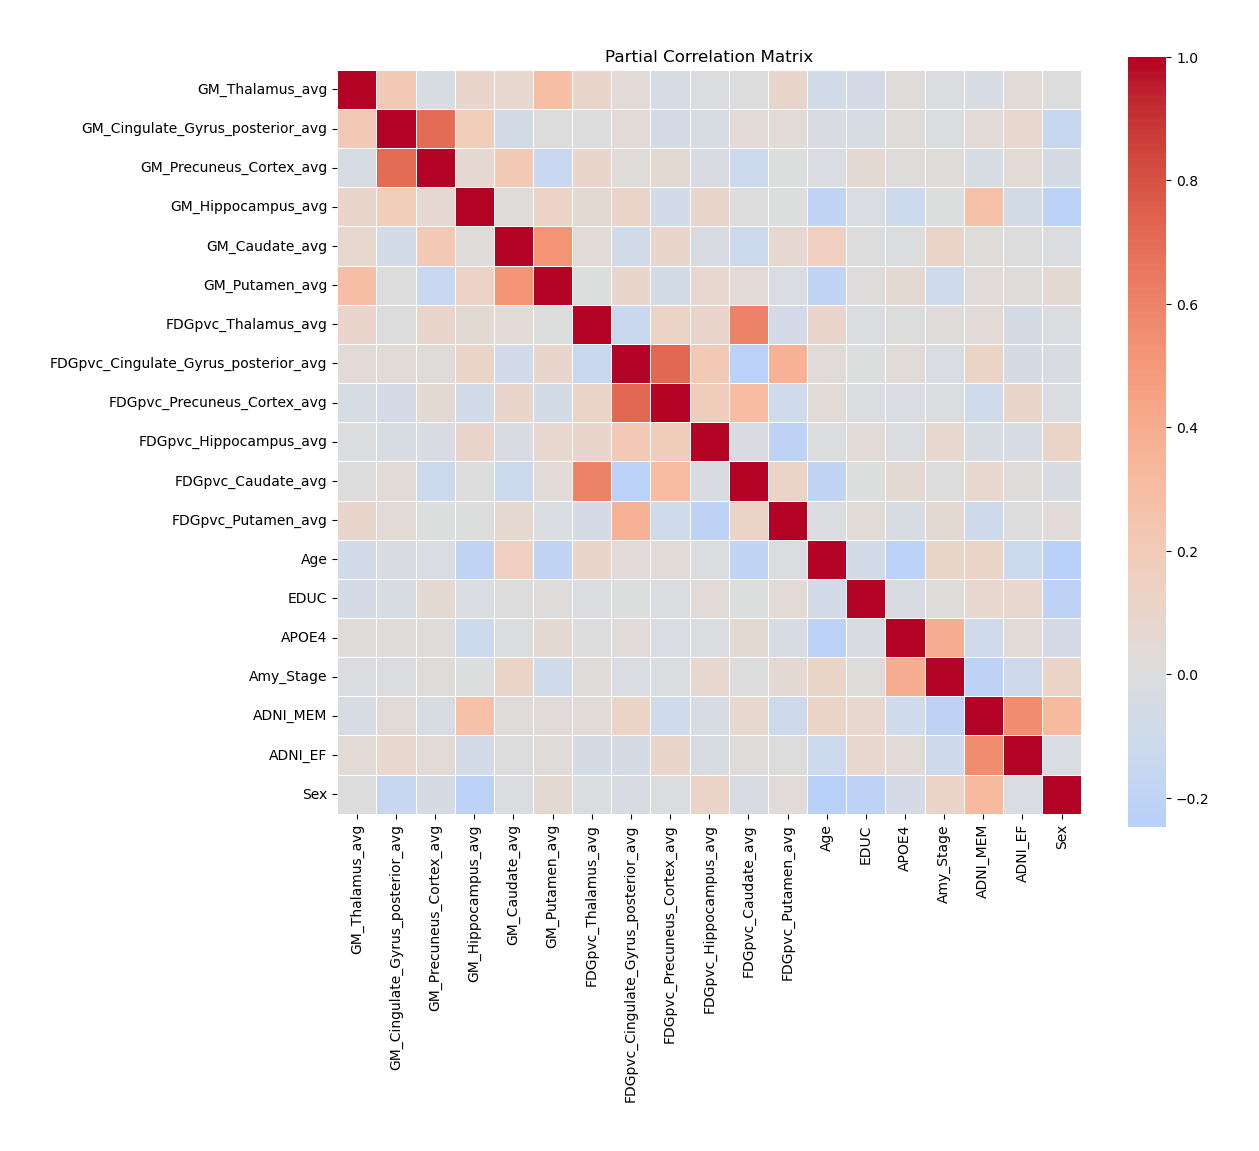

In [32]:
pcorr_matrix = pg.pcorr(df_standardized)

plt.figure(figsize=(12, 10))
sns.heatmap(pcorr_matrix, xticklabels=pcorr_matrix.columns, yticklabels=pcorr_matrix.index,
            cmap='coolwarm', center=0, annot=False, square=True, linewidths=0.5)
plt.title("Partial Correlation Matrix")
plt.show()

In [33]:
pcorr_matrix.head(20)

GM_Thalamus_avg  \
GM_Thalamus_avg                              1.000000   
GM_Cingulate_Gyrus_posterior_avg             0.217822   
GM_Precuneus_Cortex_avg                     -0.040249   
GM_Hippocampus_avg                           0.094726   
GM_Caudate_avg                               0.078457   
GM_Putamen_avg                               0.290662   
FDGpvc_Thalamus_avg                          0.094560   
FDGpvc_Cingulate_Gyrus_posterior_avg         0.034320   
FDGpvc_Precuneus_Cortex_avg                 -0.051862   
FDGpvc_Hippocampus_avg                      -0.011739   
FDGpvc_Caudate_avg                           0.004417   
FDGpvc_Putamen_avg                           0.093267   
Age                                         -0.082934   
EDUC                                        -0.064212   
APOE4                                        0.018864   
Amy_Stage                                   -0.013942   
ADNI_MEM                                    -0.038114   
ADNI_EF                                      0.048872   
Sex                                          0.002002   

                                      GM_Cingulate_Gyrus_posterior_avg  \
GM_Thalamus_avg                                               0.217822   
GM_Cingulate_Gyrus_posterior_avg                              1.000000   
GM_Precuneus_Cortex_avg                                       0.698943   
GM_Hippocampus_avg                                            0.182305   
GM_Caudate_avg                                               -0.071340   
GM_Putamen_avg                                                0.003146   
FDGpvc_Thalamus_avg                                           0.006712   
FDGpvc_Cingulate_Gyrus_posterior_avg                          0.033929   
FDGpvc_Precuneus_Cortex_avg                                  -0.064521   
FDGpvc_Hippocampus_avg                                       -0.041899   
FDGpvc_Caudate_avg                                            0.034777   
FDGpvc_Putamen_avg                                            0.046653   
Age                                                          -0.032301   
EDUC                                                         -0.038974   
APOE4                                                         0.018871   
Amy_Stage                                                    -0.018410   
ADNI_MEM                                                      0.030801   
ADNI_EF                                                       0.087493   
Sex                                                          -0.149451   

                                      GM_Precuneus_Cortex_avg  \
GM_Thalamus_avg                                     -0.040249   
GM_Cingulate_Gyrus_posterior_avg                     0.698943   
GM_Precuneus_Cortex_avg                              1.000000   
GM_Hippocampus_avg                                   0.067609   
GM_Caudate_avg                                       0.218733   
GM_Putamen_avg                                      -0.140487   
FDGpvc_Thalamus_avg                                  0.094638   
FDGpvc_Cingulate_Gyrus_posterior_avg                 0.016702   
FDGpvc_Precuneus_Cortex_avg                          0.053646   
FDGpvc_Hippocampus_avg                              -0.033925   
FDGpvc_Caudate_avg                                  -0.125044   
FDGpvc_Putamen_avg                                  -0.001774   
Age                                                 -0.025160   
EDUC                                                 0.064004   
APOE4                                                0.013213   
Amy_Stage                                            0.018540   
ADNI_MEM                                            -0.040956   
ADNI_EF                                              0.044317   
Sex                                                 -0.061083   

                                      GM_Hippocampus_avg  GM_Caudate_avg  \
GM_Thalamus_avg                        

In [34]:
pcorr_matrix.to_excel("pcorr for 1st.xlsx")

In [35]:
n = df_standardized.shape[0]
variable_names = pcorr_matrix.columns
k = len(variable_names) 
df_t = n - k - 2

t_matrix = pd.DataFrame(index=variable_names, columns=variable_names, dtype=float)
p_matrix = pd.DataFrame(index=variable_names, columns=variable_names, dtype=float)

for i in range(len(variable_names)):
    for j in range(i + 1, len(variable_names)):
        var_i = variable_names[i]
        var_j = variable_names[j]
        r = pcorr_matrix.loc[var_i, var_j]

        if abs(r) == 1:
            t = np.inf
            p = 0.0
        else:
            t = r / np.sqrt((1 - r**2) / df_t)
            p = 2 * (1 - t_dist.cdf(abs(t), df_t))

        t_matrix.loc[var_i, var_j] = t
        t_matrix.loc[var_j, var_i] = t
        p_matrix.loc[var_i, var_j] = p
        p_matrix.loc[var_j, var_i] = p

In [36]:
t_matrix

GM_Thalamus_avg  \
GM_Thalamus_avg                                   NaN   
GM_Cingulate_Gyrus_posterior_avg             7.099822   
GM_Precuneus_Cortex_avg                     -1.281446   
GM_Hippocampus_avg                           3.027035   
GM_Caudate_avg                               2.503603   
GM_Putamen_avg                               9.663766   
FDGpvc_Thalamus_avg                          3.021674   
FDGpvc_Cingulate_Gyrus_posterior_avg         1.092427   
FDGpvc_Precuneus_Cortex_avg                 -1.652046   
FDGpvc_Hippocampus_avg                      -0.373472   
FDGpvc_Caudate_avg                           0.140515   
FDGpvc_Putamen_avg                           2.979999   
Age                                         -2.647425   
EDUC                                        -2.046949   
APOE4                                        0.600223   
Amy_Stage                                   -0.443579   
ADNI_MEM                                    -1.213358   
ADNI_EF                                      1.556585   
Sex                                          0.063699   

                                      GM_Cingulate_Gyrus_posterior_avg  \
GM_Thalamus_avg                                               7.099822   
GM_Cingulate_Gyrus_posterior_avg                                   NaN   
GM_Precuneus_Cortex_avg                                      31.089798   
GM_Hippocampus_avg                                            5.898306   
GM_Caudate_avg                                               -2.275248   
GM_Putamen_avg                                                0.100091   
FDGpvc_Thalamus_avg                                           0.213521   
FDGpvc_Cingulate_Gyrus_posterior_avg                          1.079975   
FDGpvc_Precuneus_Cortex_avg                                  -2.056832   
FDGpvc_Hippocampus_avg                                       -1.334073   
FDGpvc_Caudate_avg                                            1.107005   
FDGpvc_Putamen_avg                                            1.485745   
Age                                                          -1.028104   
EDUC                                                         -1.240769   
APOE4                                                         0.600427   
Amy_Stage                                                    -0.585768   
ADNI_MEM                                                      0.980308   
ADNI_EF                                                       2.794039   
Sex                                                          -4.808321   

                                      GM_Precuneus_Cortex_avg  \
GM_Thalamus_avg                                     -1.281446   
GM_Cingulate_Gyrus_posterior_avg                    31.089798   
GM_Precuneus_Cortex_avg                                   NaN   
GM_Hippocampus_avg                                   2.155712   
GM_Caudate_avg                                       7.131006   
GM_Putamen_avg                                      -4.513920   
FDGpvc_Thalamus_avg                                  3.024189   
FDGpvc_Cingulate_Gyrus_posterior_avg                 0.531413   
FDGpvc_Precuneus_Cortex_avg                          1.709061   
FDGpvc_Hippocampus_avg                              -1.079850   
FDGpvc_Caudate_avg                                  -4.009362   
FDGpvc_Putamen_avg                                  -0.056448   
Age                                                 -0.800631   
EDUC                                                 2.040285   
APOE4                                                0.420377   
Amy_Stage                                            0.589900   
ADNI_MEM                                            -1.303989   
ADNI_EF                                              1.411183   
Sex                                                 -1.946819   

                                      GM_Hippocampus_avg  GM_Caudate_avg  \
GM_Thalamus_avg                        

In [37]:
t_matrix.to_excel("t matrix for 1.xlsx")

In [38]:
p_matrix

GM_Thalamus_avg  \
GM_Thalamus_avg                                   NaN   
GM_Cingulate_Gyrus_posterior_avg         2.349454e-12   
GM_Precuneus_Cortex_avg                  2.003305e-01   
GM_Hippocampus_avg                       2.532168e-03   
GM_Caudate_avg                           1.245015e-02   
GM_Putamen_avg                           0.000000e+00   
FDGpvc_Thalamus_avg                      2.577027e-03   
FDGpvc_Cingulate_Gyrus_posterior_avg     2.749056e-01   
FDGpvc_Precuneus_Cortex_avg              9.883543e-02   
FDGpvc_Hippocampus_avg                   7.088751e-01   
FDGpvc_Caudate_avg                       8.882807e-01   
FDGpvc_Putamen_avg                       2.951364e-03   
Age                                      8.236788e-03   
EDUC                                     4.092098e-02   
APOE4                                    5.484919e-01   
Amy_Stage                                6.574422e-01   
ADNI_MEM                                 2.252761e-01   
ADNI_EF                                  1.198818e-01   
Sex                                      9.492226e-01   

                                      GM_Cingulate_Gyrus_posterior_avg  \
GM_Thalamus_avg                                           2.349454e-12   
GM_Cingulate_Gyrus_posterior_avg                                   NaN   
GM_Precuneus_Cortex_avg                                   0.000000e+00   
GM_Hippocampus_avg                                        5.002300e-09   
GM_Caudate_avg                                            2.309948e-02   
GM_Putamen_avg                                            9.202922e-01   
FDGpvc_Thalamus_avg                                       8.309633e-01   
FDGpvc_Cingulate_Gyrus_posterior_avg                      2.804105e-01   
FDGpvc_Precuneus_Cortex_avg                               3.995824e-02   
FDGpvc_Hippocampus_avg                                    1.824802e-01   
FDGpvc_Caudate_avg                                        2.685550e-01   
FDGpvc_Putamen_avg                                        1.376581e-01   
Age                                                       3.041464e-01   
EDUC                                                      2.149788e-01   
APOE4                                                     5.483564e-01   
Amy_Stage                                                 5.581621e-01   
ADNI_MEM                                                  3.271686e-01   
ADNI_EF                                                   5.303712e-03   
Sex                                                       1.752830e-06   

                                      GM_Precuneus_Cortex_avg  \
GM_Thalamus_avg                                  2.003305e-01   
GM_Cingulate_Gyrus_posterior_avg                 0.000000e+00   
GM_Precuneus_Cortex_avg                                   NaN   
GM_Hippocampus_avg                               3.134133e-02   
GM_Caudate_avg                                   1.894263e-12   
GM_Putamen_avg                                   7.111088e-06   
FDGpvc_Thalamus_avg                              2.555894e-03   
FDGpvc_Cingulate_Gyrus_posterior_avg             5.952491e-01   
FDGpvc_Precuneus_Cortex_avg                      8.774631e-02   
FDGpvc_Hippocampus_avg                           2.804663e-01   
FDGpvc_Caudate_avg                               6.535531e-05   
FDGpvc_Putamen_avg                               9.549958e-01   
Age                                              4.235335e-01   
EDUC                                             4.158113e-02   
APOE4                                            6.742996e-01   
Amy_Stage                                        5.553897e-01   
ADNI_MEM                                         1.925339e-01   
ADNI_EF                                          1.584980e-01   
Sex                                              5.183278e-02   

                                      GM_Hippocampus_avg  GM_Caudate_avg  \
GM_Thalamus_avg                        

In [39]:
p_matrix.to_excel("p matrix for 1 .xlsx")

In [40]:
pvals = []
pairs = []

for i in range(len(variable_names)):
    for j in range(i + 1, len(variable_names)):
        var_i = variable_names[i]
        var_j = variable_names[j]
        p = p_matrix.loc[var_i, var_j]
        pvals.append(p)
        pairs.append((var_i, var_j))


reject, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')


significant_pairs = [(pair[0], pair[1], pval_corr)
                     for pair, keep, pval_corr in zip(pairs, reject, pvals_corrected) if keep]


significant_df = pd.DataFrame(significant_pairs, columns=['Variable 1', 'Variable 2', 'Corrected p-value'])
significant_df.sort_values('Corrected p-value', inplace=True)

print(significant_df.shape)
significant_df

(71, 3)


Variable 1  \
70                              ADNI_MEM   
23                        GM_Caudate_avg   
69                              ADNI_MEM   
36                   FDGpvc_Thalamus_avg   
38  FDGpvc_Cingulate_Gyrus_posterior_avg   
7       GM_Cingulate_Gyrus_posterior_avg   
21                    GM_Hippocampus_avg   
44           FDGpvc_Precuneus_Cortex_avg   
3                        GM_Thalamus_avg   
64                                 APOE4   
41  FDGpvc_Cingulate_Gyrus_posterior_avg   
60                                   Age   
40  FDGpvc_Cingulate_Gyrus_posterior_avg   
22                    GM_Hippocampus_avg   
39  FDGpvc_Cingulate_Gyrus_posterior_avg   
56                                   Age   
11               GM_Precuneus_Cortex_avg   
0                        GM_Thalamus_avg   
48                FDGpvc_Hippocampus_avg   
66                             Amy_Stage   
63                                  EDUC   
31                        GM_Putamen_avg   
52                    FDGpvc_Caudate_avg   
19                    GM_Hippocampus_avg   
8       GM_Cingulate_Gyrus_posterior_avg   
43           FDGpvc_Precuneus_Cortex_avg   
27                        GM_Caudate_avg   
10      GM_Cingulate_Gyrus_posterior_avg   
12               GM_Precuneus_Cortex_avg   
33                   FDGpvc_Thalamus_avg   
15                    GM_Hippocampus_avg   
14               GM_Precuneus_Cortex_avg   
51                    FDGpvc_Caudate_avg   
34                   FDGpvc_Thalamus_avg   
59                                   Age   
26                        GM_Caudate_avg   
42  FDGpvc_Cingulate_Gyrus_posterior_avg   
68                             Amy_Stage   
58                                   Age   
16                    GM_Hippocampus_avg   
50                FDGpvc_Hippocampus_avg   
28                        GM_Caudate_avg   
20                    GM_Hippocampus_avg   
67                             Amy_Stage   
57                                   Age   
54                    FDGpvc_Putamen_avg   
18                    GM_Hippocampus_avg   
25                        GM_Caudate_avg   
37                   FDGpvc_Thalamus_avg   
46           FDGpvc_Precuneus_Cortex_avg   
35                   FDGpvc_Thalamus_avg   
32                        GM_Putamen_avg   
45           FDGpvc_Precuneus_Cortex_avg   
1                        GM_Thalamus_avg   
4                        GM_Thalamus_avg   
13               GM_Precuneus_Cortex_avg   
47           FDGpvc_Precuneus_Cortex_avg   
65                                 APOE4   
5                        GM_Thalamus_avg   
29                        GM_Putamen_avg   
24                        GM_Caudate_avg   
9       GM_Cingulate_Gyrus_posterior_avg   
62                                  EDUC   
55                                   Age   
6                        GM_Thalamus_avg   
17                    GM_Hippocampus_avg   
61                                  EDUC   
30                        GM_Putamen_avg   
49                FDGpvc_Hippocampus_avg   
2                        GM_Thalamus_avg   
53                    FDGpvc_Caudate_avg   

                              Variable 2  Corrected p-value  
70                                   Sex       0.000000e+00  
23                        GM_Putamen_avg       0.000000e+00  
69                               ADNI_EF       0.000000e+00  
36                    FDGpvc_Caudate_avg       0.000000e+00  
38           FDGpvc_Precuneus_Cortex_avg       0.000000e+00  
7                GM_Precuneus_Cortex_avg       0.000000e+00  
21                              ADNI_MEM       0.000000e+00  
44                    FDGpvc_Caudate_avg       0.000000e+00  
3                         GM_Putamen_avg       0.000000e+00  
64                             Amy_Stage       0.000000e+00  
41                    FDGpvc_Putamen_avg       0.000000e+00  
60                                   Sex       1.898481e-14  
40                    FDGpvc_Caudate_avg       4.436605

In [41]:
significant_df.to_excel("sig_df1.xlsx")

C:\Users\aleksander\AppData\Local\Temp\ipykernel_7300\2517138665.py:25: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=weights, edge_color=colors)


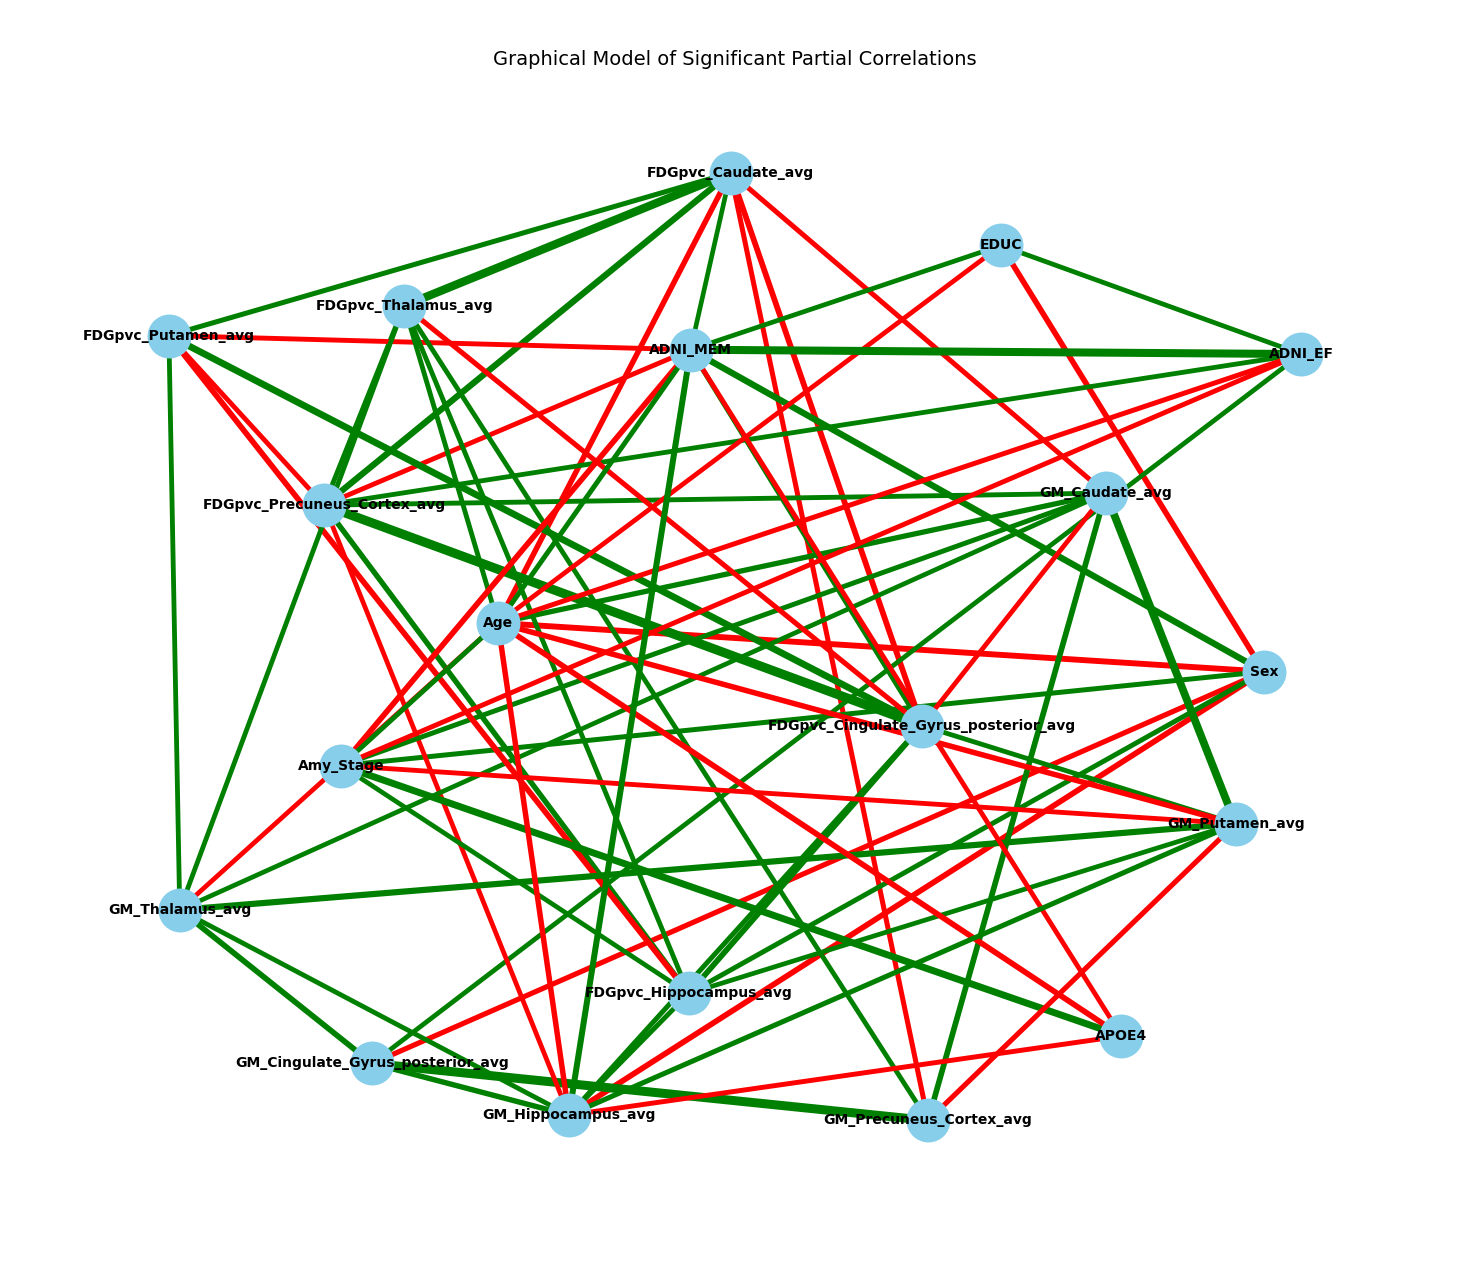

In [42]:
G = nx.Graph()
G.add_nodes_from(set(significant_df['Variable 1']).union(significant_df['Variable 2']))

# Step 2: Add edges with signed weights from partial correlation matrix
for _, row in significant_df.iterrows():
    var1 = row['Variable 1']
    var2 = row['Variable 2']
    r = pcorr_matrix.loc[var1, var2]  # signed partial correlation
    G.add_edge(var1, var2, weight=abs(r), sign=np.sign(r))

plt.figure(figsize=(14, 12))

# Try a spaced-out layout
pos = nx.spring_layout(G, seed=42, k=1.5)  # Increase k for more spacing

# Node drawing
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Edge styling
edges = G.edges(data=True)
weights = [3 + 5 * edge[2]['weight'] for edge in edges]  # thickness
colors = ['red' if edge[2]['sign'] < 0 else 'green' for edge in edges]

nx.draw_networkx_edges(G, pos, width=weights, edge_color=colors)

plt.title("Graphical Model of Significant Partial Correlations", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()
plt.show()

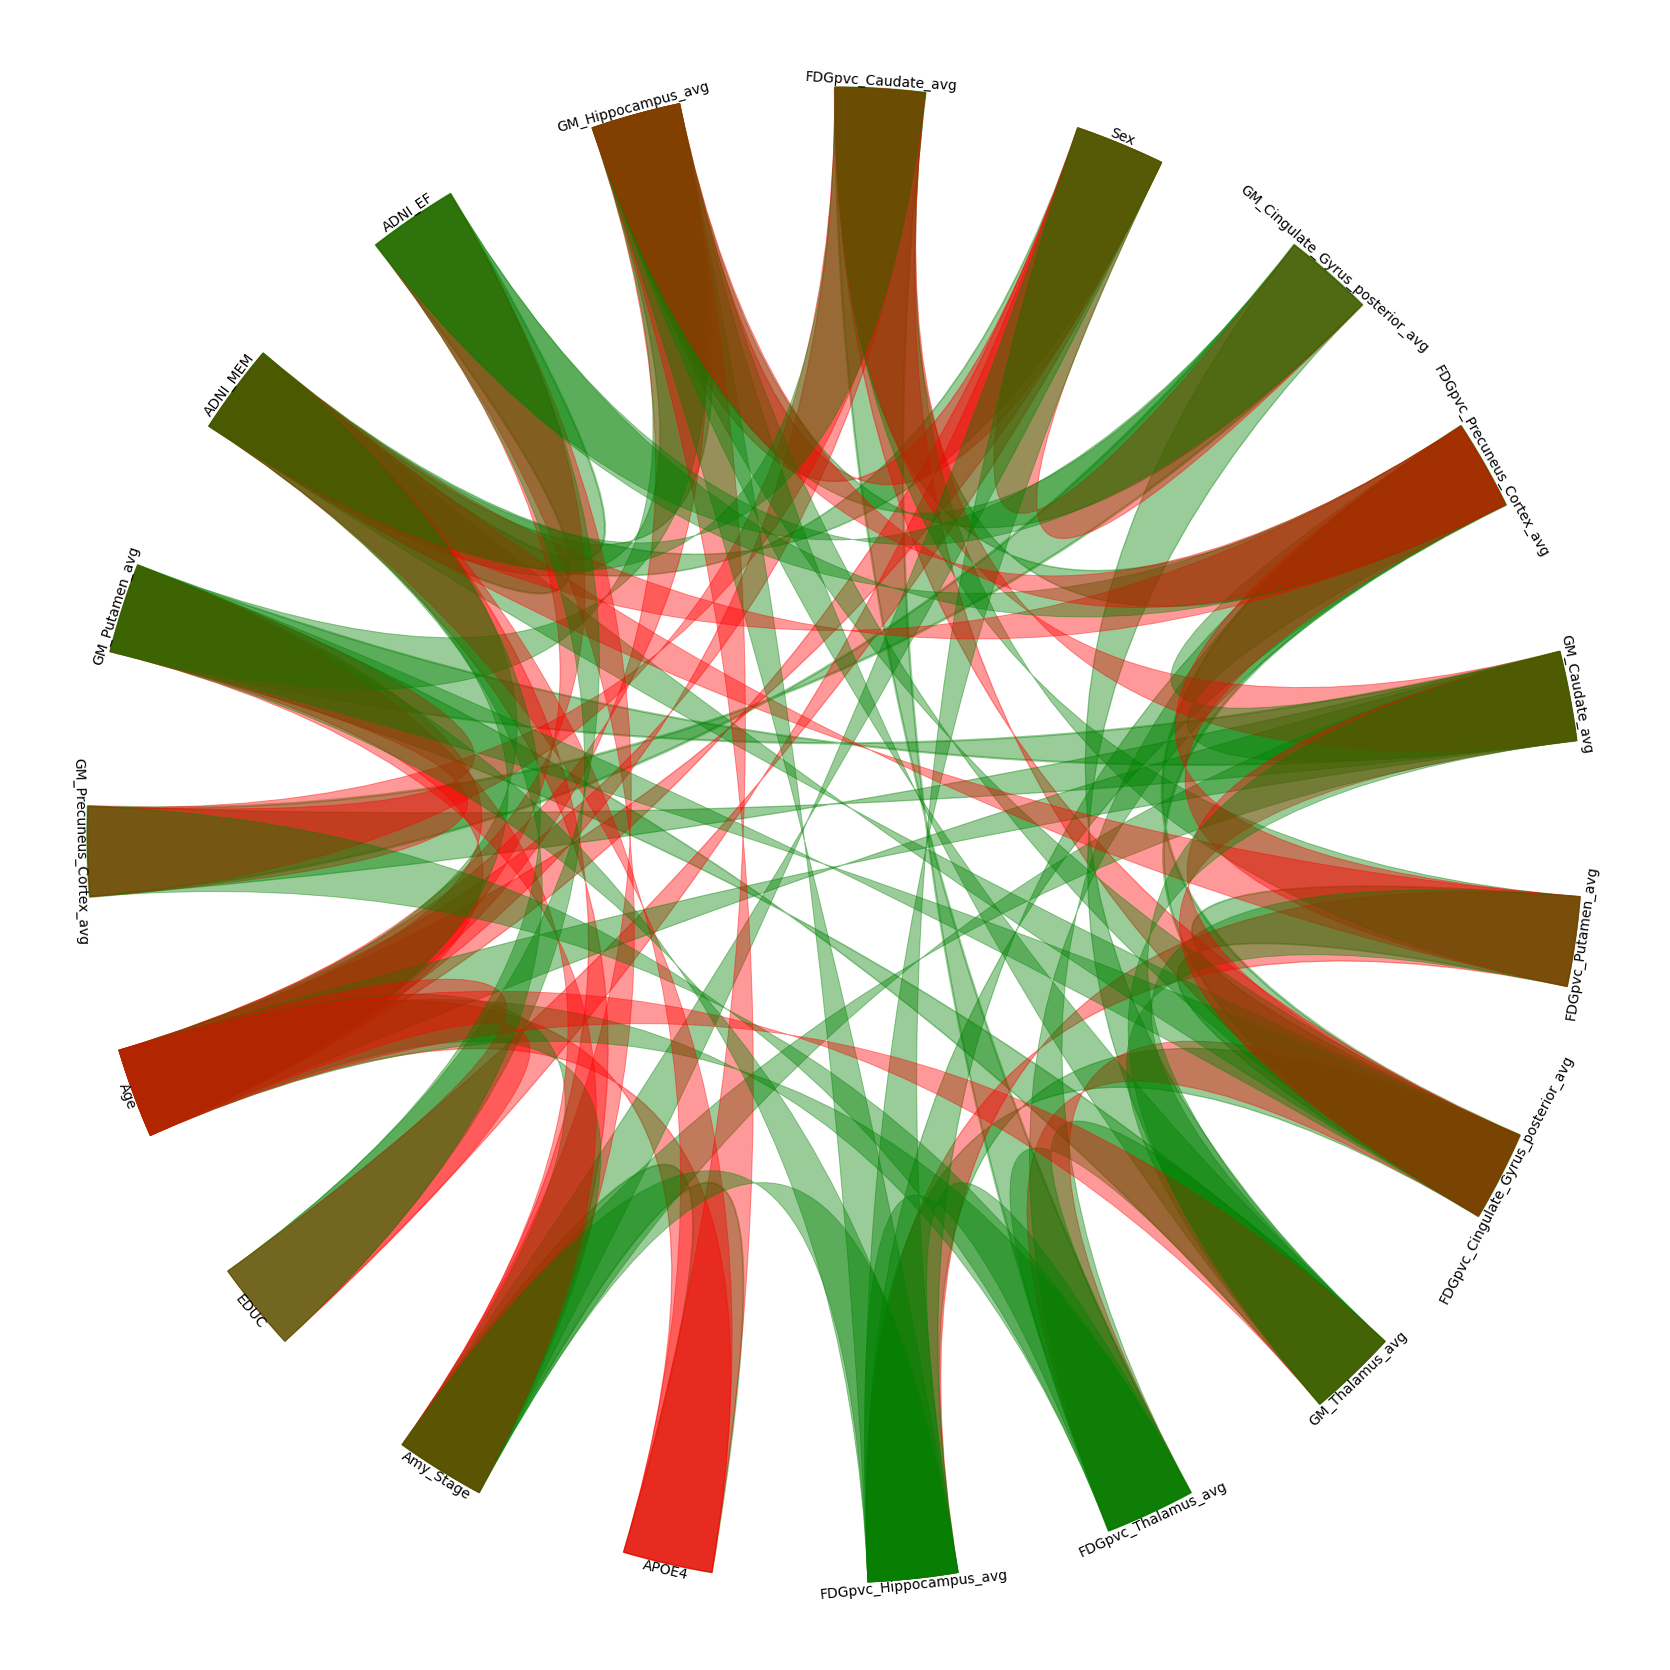

In [43]:
nodes = list(set(significant_df['Variable 1']).union(significant_df['Variable 2']))

sectors = {node: (0, 1) for node in nodes}

circos = Circos(sectors, space=12, start=0, end=360)

for sector in circos.sectors:
    sector.text(sector.name, r=100, size=10, ha='center', va='center', rotation='tangential', color='black')

top_n = 100
significant_df['abs_r'] = significant_df.apply(lambda row: abs(pcorr_matrix.loc[row['Variable 1'], row['Variable 2']]), axis=1)
top_links = significant_df.nlargest(top_n, 'abs_r')

for _, row in top_links.iterrows():
    var1 = row['Variable 1']
    var2 = row['Variable 2']
    r = pcorr_matrix.loc[var1, var2]
    color = 'red' if np.sign(r) < 0 else 'green'
    width = 0.5 + 2 * abs(r)
    circos.link((var1, 0, 1), (var2, 0, 1), color=color, linewidth=width, alpha=0.4)

fig = circos.plotfig()
fig.set_size_inches(16, 16)
plt.show()

In [44]:
df_merged.head()

RID  diagnosis  Sex   Age  EDUC  MMSE  MRI_Field_Strength  site   TIV  \
0   21          1    1  77.7    18    29                 3.0    11  1281   
1   23          1    0  77.0    14    26                 3.0    11  1370   
2   31          1    1  83.0    18    30                 1.5    23  1257   
3   42          4    0  78.0    18    23                 1.5    23  1411   
4   47          1    0  90.0    20    30                 1.5   100  1516   

   FDG.pons  AV45.whole.cerebellum  APOE4  SUMMARYSUVR_WHOLECEREBNORM  \
0  0.773000               1.139200    0.0                      1.0020   
1  0.788999               1.088983    0.0                      1.1242   
2  0.907775               1.086025    0.0                      1.2142   
3  0.979412               0.915848    0.0                      1.0009   
4  0.840300               0.996673    0.0                      1.0034   

   SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF Amy_Stage  LDELTOTAL  BNTSPONT  \
0                                    0.0         0       11.0      30.0   
1                                    1.0         0       26.0      27.0   
2                                    1.0         2       30.0      30.0   
3                                    0.0         0        0.0      27.0   
4                                    0.0         0       12.0      28.0   

   BNTTOTAL  TRAASCOR  TRABSCOR  TRAB-A  AVDEL30MIN  AVDELTOT  LIMMTOTAL  \
0      30.0      33.0      55.0    22.0        12.0      15.0       14.0   
1      27.0      40.0      76.0    36.0         4.0      14.0       13.0   
2      30.0      44.0      64.0    20.0         7.0      14.0       21.0   
3      27.0      51.0     115.0    64.0         0.0       0.0        6.0   
4      29.0      38.0     101.0    63.0         6.0      12.0       15.0   

   CDR (CDGLOBAL) at scan ADNI_MEM ADNI_EF  T1_year  ABETA   TAU  PTAU  \
0                     NaN    1.691   1.132     2010    NaN   NaN   NaN   
1                     0.0    0.757   -0.05     2010    NaN   NaN   NaN   
2                     0.0    1.462   0.266     2010  133.0  44.9  91.2   
3                     1.0   -1.208  -0.105     2011  241.0  60.2  44.3   
4                     0.0    0.659   0.535     2011    NaN   NaN   NaN   

   Abeta_pos  GM_Frontal_Pole_avg  GM_Insular_Cortex_avg  \
0        NaN         18943.000000            5959.500000   
1        NaN         17999.449778            5349.247578   
2        1.0         16861.297956            4911.357370   
3        0.0         13966.082367            4275.147125   
4        NaN         15497.563567            4464.235220   

   GM_Superior_Frontal_Gyrus_avg  GM_Middle_Frontal_Gyrus_avg  \
0                    6822.500000                  5679.000000   
1                    6919.989226                  6359.769588   
2                    6759.906549                  5837.163327   
3                    6628.000411                  6196.315366   
4                    5768.615392                  6092.257837   

   GM_Inferior_Frontal_Gyrus_pars_triangularis_avg  \
0                                      1488.000000   
1                                      1656.173381   
2                                      1381.010992   
3                                      1198.460214   
4                                      1065.722714   

   GM_Inferior_Frontal_Gyrus_pars_opercularis_avg  GM_Precentral_Gyrus_avg  \
0                                     1810.500000              7460.000000   
1                                     1965.202462              8305.062875   
2                                     1669.405031              8004.645202   
3                                     1467.379783              7173.187636   
4                                     1241.920335              6253.605946   

   GM_Temporal_Pole_avg  GM_Superior_Temporal_Gyrus_anterior_avg  \
0           6475.500000                               990.000000   
1           7148.133474                               885.565178   
2   

### All variables Set

In [46]:
#df_merged.isna().sum()
#df_merged.dtypes

In [47]:
df_numeric_all = df_merged.apply(pd.to_numeric, errors='coerce')

In [48]:
imputer = IterativeImputer(random_state=0, max_iter=20)

df_imputed_array = imputer.fit_transform(df_numeric_all)

df_imputed = pd.DataFrame(df_imputed_array, columns=df_numeric_all.columns, index=df_numeric_all.index)

In [49]:
df_imputed_1 = df_imputed.drop(['RID', 'T1_year'], axis = 1)

In [50]:
#df_imputed.isna().sum()

In [51]:
df_imputed_1.head()

diagnosis  Sex   Age  EDUC  MMSE  MRI_Field_Strength   site     TIV  \
0        1.0  1.0  77.7  18.0  29.0                 3.0   11.0  1281.0   
1        1.0  0.0  77.0  14.0  26.0                 3.0   11.0  1370.0   
2        1.0  1.0  83.0  18.0  30.0                 1.5   23.0  1257.0   
3        4.0  0.0  78.0  18.0  23.0                 1.5   23.0  1411.0   
4        1.0  0.0  90.0  20.0  30.0                 1.5  100.0  1516.0   

   FDG.pons  AV45.whole.cerebellum  APOE4  SUMMARYSUVR_WHOLECEREBNORM  \
0  0.773000               1.139200    0.0                      1.0020   
1  0.788999               1.088983    0.0                      1.1242   
2  0.907775               1.086025    0.0                      1.2142   
3  0.979412               0.915848    0.0                      1.0009   
4  0.840300               0.996673    0.0                      1.0034   

   SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF  Amy_Stage  LDELTOTAL  BNTSPONT  \
0                                    0.0        0.0       11.0      30.0   
1                                    1.0        0.0       26.0      27.0   
2                                    1.0        2.0       30.0      30.0   
3                                    0.0        0.0        0.0      27.0   
4                                    0.0        0.0       12.0      28.0   

   BNTTOTAL  TRAASCOR  TRABSCOR  TRAB-A  AVDEL30MIN  AVDELTOT  LIMMTOTAL  \
0      30.0      33.0      55.0    22.0        12.0      15.0       14.0   
1      27.0      40.0      76.0    36.0         4.0      14.0       13.0   
2      30.0      44.0      64.0    20.0         7.0      14.0       21.0   
3      27.0      51.0     115.0    64.0         0.0       0.0        6.0   
4      29.0      38.0     101.0    63.0         6.0      12.0       15.0   

   CDR (CDGLOBAL) at scan  ADNI_MEM  ADNI_EF       ABETA        TAU  \
0                0.006222     1.691    1.132  252.603616  47.155790   
1                0.000000     0.757   -0.050  210.665805  62.780299   
2                0.000000     1.462    0.266  133.000000  44.900000   
3                1.000000    -1.208   -0.105  241.000000  60.200000   
4                0.000000     0.659    0.535  205.437870  85.938061   

        PTAU  Abeta_pos  GM_Frontal_Pole_avg  GM_Insular_Cortex_avg  \
0  20.804282  -0.018967         18943.000000            5959.500000   
1  27.352192   0.398908         17999.449778            5349.247578   
2  91.200000   1.000000         16861.297956            4911.357370   
3  44.300000   0.000000         13966.082367            4275.147125   
4  35.059381   0.441947         15497.563567            4464.235220   

   GM_Superior_Frontal_Gyrus_avg  GM_Middle_Frontal_Gyrus_avg  \
0                    6822.500000                  5679.000000   
1                    6919.989226                  6359.769588   
2                    6759.906549                  5837.163327   
3                    6628.000411                  6196.315366   
4                    5768.615392                  6092.257837   

   GM_Inferior_Frontal_Gyrus_pars_triangularis_avg  \
0                                      1488.000000   
1                                      1656.173381   
2                                      1381.010992   
3                                      1198.460214   
4                                      1065.722714   

   GM_Inferior_Frontal_Gyrus_pars_opercularis_avg  GM_Precentral_Gyrus_avg  \
0                                     1810.500000              7460.000000   
1                                     1965.202462              8305.062875   
2                                     1669.405031              8004.645202   
3                                     1467.379783              7173.187636   
4                                     1241.920335              6253.605946   

   GM_Temporal_Pole_avg  GM_Superior_Temporal_Gyrus_anterior_avg  \
0           6475.500000                               990.000000   
1           7148.133474       

In [52]:
non_standardized_cols = ['Sex', 'diagnosis'] 

to_standardize = df_imputed_1.drop(columns=non_standardized_cols)
not_standardized = df_imputed_1[non_standardized_cols]

scaler = StandardScaler()
standardized_part = pd.DataFrame(scaler.fit_transform(to_standardize), columns=to_standardize.columns, index=to_standardize.index)

df_standardized = pd.concat([standardized_part, not_standardized], axis=1)

In [53]:
df_standardized.head()

Age      EDUC      MMSE  MRI_Field_Strength      site       TIV  \
0  0.536021  0.666497  0.531194            0.410461 -0.558508 -0.880497   
1  0.442753 -0.822302 -0.468281            0.410461 -0.558508 -0.234631   
2  1.242192  0.666497  0.864352           -2.436285 -0.455905 -1.054663   
3  0.575993  0.666497 -1.467756           -2.436285 -0.455905  0.062902   
4  2.174871  1.410896  0.864352           -2.436285  0.202461  0.824878   

   FDG.pons  AV45.whole.cerebellum     APOE4  SUMMARYSUVR_WHOLECEREBNORM  \
0 -0.665191               0.520129 -0.816843                   -0.864621   
1 -0.438583              -0.178777 -0.816843                   -0.330821   
2  1.243747              -0.219946 -0.816843                    0.062322   
3  2.258405              -2.588423 -0.816843                   -0.869426   
4  0.288038              -1.463522 -0.816843                   -0.858505   

   SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF  Amy_Stage  LDELTOTAL  BNTSPONT  \
0                              -1.045548  -1.102078   0.477323  0.895332   
1                               0.957090  -1.102078   3.263258  0.183440   
2                               0.957090   0.137684   4.006174  0.895332   
3                              -1.045548  -1.102078  -1.565696  0.183440   
4                              -1.045548  -1.102078   0.663052  0.420737   

   BNTTOTAL  TRAASCOR  TRABSCOR    TRAB-A  AVDEL30MIN  AVDELTOT  LIMMTOTAL  \
0  0.805636 -0.372065 -0.839845 -0.867440    1.595630  1.074213   0.765831   
1  0.121202 -0.061551 -0.533934 -0.620988   -0.205349  0.810975   0.558530   
2  0.805636  0.115885 -0.708740 -0.902647    0.470018  0.810975   2.216937   
3  0.121202  0.426399  0.034186 -0.128084   -1.105838 -2.874349  -0.892576   
4  0.577491 -0.150269 -0.169755 -0.145688    0.244896  0.284500   0.973131   

   CDR (CDGLOBAL) at scan  ADNI_MEM   ADNI_EF     ABETA       TAU      PTAU  \
0               -1.030323  1.417485  0.835993  1.462711 -0.804732 -0.871370   
1               -1.048723  0.416524 -0.351880  0.653530 -0.493879 -0.592633   
2               -1.048723  1.172067 -0.034310 -0.845015 -0.849612  2.125296   
3                1.908421 -1.689353 -0.407153  1.238822 -0.545215  0.128816   
4               -1.048723  0.311498  0.236027  0.552658 -0.033150 -0.264546   

   Abeta_pos  GM_Frontal_Pole_avg  GM_Insular_Cortex_avg  \
0  -1.348374             0.353345               1.019969   
1  -0.442145            -0.029669               0.066823   
2   0.861421            -0.491678              -0.617112   
3  -1.307241            -1.666930              -1.610802   
4  -0.348808            -1.045258              -1.315467   

   GM_Superior_Frontal_Gyrus_avg  GM_Middle_Frontal_Gyrus_avg  \
0                      -0.391903                    -0.870915   
1                      -0.293371                    -0.120974   
2                      -0.455165                    -0.696681   
3                      -0.588481                    -0.301037   
4                      -1.457054                    -0.415667   

   GM_Inferior_Frontal_Gyrus_pars_triangularis_avg  \
0                                        -0.016823   
1                                         0.697864   
2                                        -0.471495   
3                                        -1.247283   
4                                        -1.811378   

   GM_Inferior_Frontal_Gyrus_pars_opercularis_avg  GM_Precentral_Gyrus_avg  \
0                                        0.258262                -0.755364   
1                                        0.868017                -0.042174   
2                                       -0.297859                -0.295711   
3                                       -1.094134                -0.997418   
4                                       -1.982775                -1.773498   

   GM_Temporal_Pole_avg  GM_Superior_Temporal_Gyrus_anterior_avg  \
0             -0.793597                                 0.298533   
1             -0.

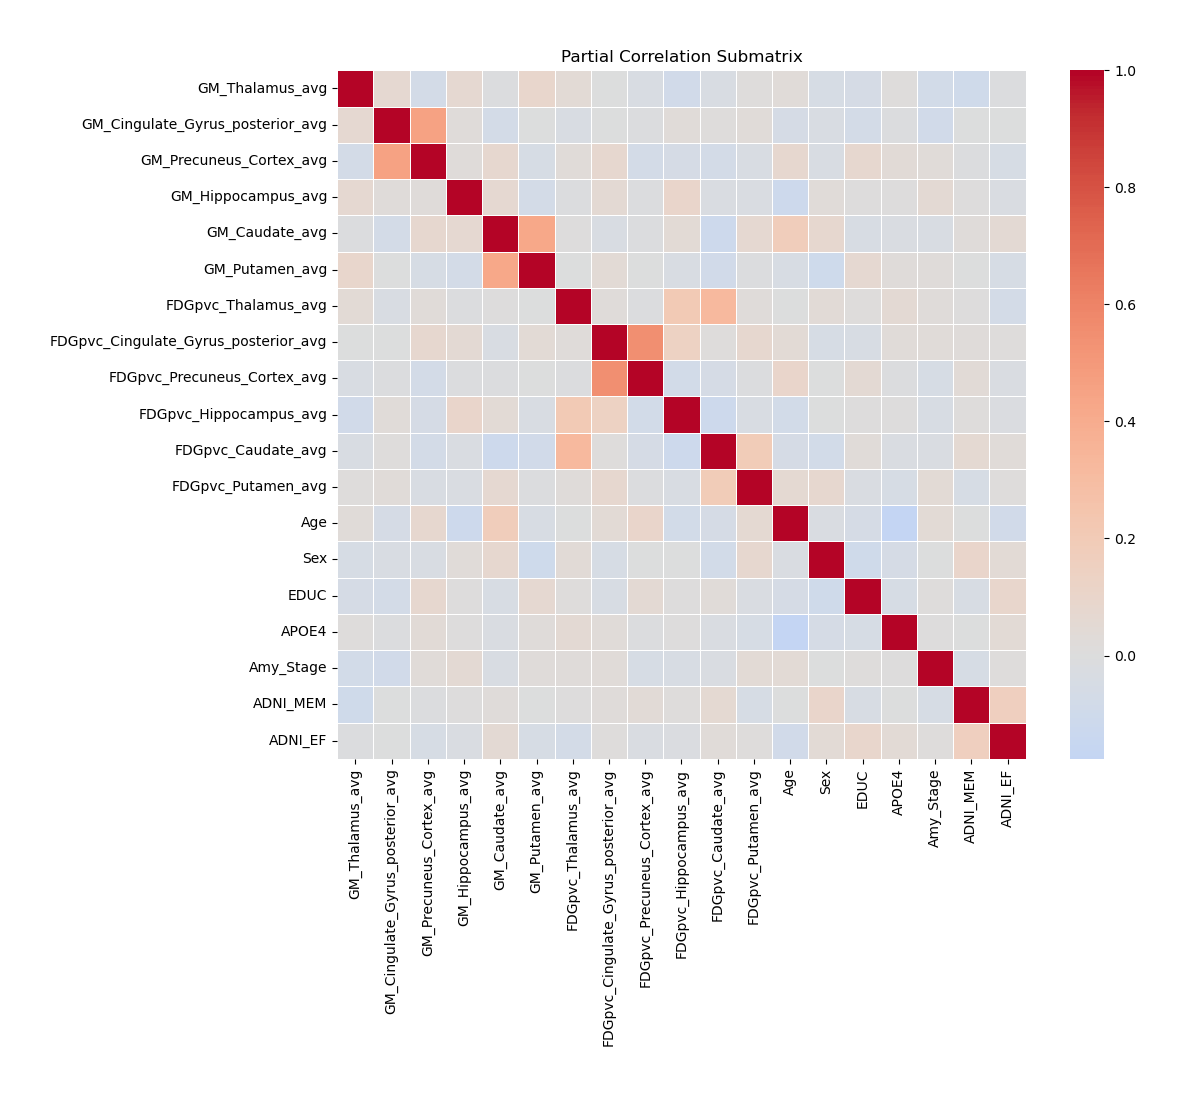

In [54]:
pcorr_matrix = pg.pcorr(df_standardized)

selected_vars = [
    #Target Variable
    #"diagnosis",
    # Gray matter (GM) volumes
    'GM_Thalamus_avg',
    'GM_Cingulate_Gyrus_posterior_avg',  # PCC
    'GM_Precuneus_Cortex_avg',
    'GM_Hippocampus_avg',
    'GM_Caudate_avg',
    'GM_Putamen_avg',

    # Glucose metabolism (FDG)
    'FDGpvc_Thalamus_avg',
    'FDGpvc_Cingulate_Gyrus_posterior_avg',  # PCC
    'FDGpvc_Precuneus_Cortex_avg',
    'FDGpvc_Hippocampus_avg',
    'FDGpvc_Caudate_avg',
    'FDGpvc_Putamen_avg',

    # Demographics
    'Age',
    'Sex',
    'EDUC',

    # Genetics & Pathology
    'APOE4',
    'Amy_Stage',

    # Cognitive composite scores
    'ADNI_MEM',
    'ADNI_EF'
]

pcorr_submatrix = pcorr_matrix.loc[selected_vars, selected_vars]

plt.figure(figsize=(12, 10))
sns.heatmap(pcorr_submatrix, xticklabels=selected_vars, yticklabels=selected_vars,
            cmap='coolwarm', center=0, annot=False, square=True, linewidths=0.5)
plt.title("Partial Correlation Submatrix")
plt.tight_layout()
plt.show()

In [55]:
pcorr_submatrix.to_excel("pcorr for 2nd.xlsx")

In [56]:
n = df_standardized.shape[0]
variable_names = pcorr_submatrix.columns
k = len(variable_names) 
df_t = n - k - 2

t_matrix = pd.DataFrame(index=variable_names, columns=variable_names, dtype=float)
p_matrix = pd.DataFrame(index=variable_names, columns=variable_names, dtype=float)

for i in range(len(variable_names)):
    for j in range(i + 1, len(variable_names)):
        var_i = variable_names[i]
        var_j = variable_names[j]
        r = pcorr_matrix.loc[var_i, var_j]

        if abs(r) == 1:
            t = np.inf
            p = 0.0
        else:
            t = r / np.sqrt((1 - r**2) / df_t)
            p = 2 * (1 - t_dist.cdf(abs(t), df_t))

        t_matrix.loc[var_i, var_j] = t
        t_matrix.loc[var_j, var_i] = t
        p_matrix.loc[var_i, var_j] = p
        p_matrix.loc[var_j, var_i] = p

In [57]:
t_matrix.head(30)

GM_Thalamus_avg  \
GM_Thalamus_avg                                   NaN   
GM_Cingulate_Gyrus_posterior_avg             2.215053   
GM_Precuneus_Cortex_avg                     -2.233656   
GM_Hippocampus_avg                           2.155146   
GM_Caudate_avg                              -0.345883   
GM_Putamen_avg                               2.791338   
FDGpvc_Thalamus_avg                          1.359550   
FDGpvc_Cingulate_Gyrus_posterior_avg        -0.026836   
FDGpvc_Precuneus_Cortex_avg                 -1.142901   
FDGpvc_Hippocampus_avg                      -2.763999   
FDGpvc_Caudate_avg                          -1.182387   
FDGpvc_Putamen_avg                           0.433366   
Age                                          1.021790   
Sex                                         -1.470357   
EDUC                                        -1.936475   
APOE4                                        0.442539   
Amy_Stage                                   -2.604735   
ADNI_MEM                                    -3.129871   
ADNI_EF                                     -0.425447   

                                      GM_Cingulate_Gyrus_posterior_avg  \
GM_Thalamus_avg                                               2.215053   
GM_Cingulate_Gyrus_posterior_avg                                   NaN   
GM_Precuneus_Cortex_avg                                      16.775751   
GM_Hippocampus_avg                                            0.811128   
GM_Caudate_avg                                               -2.343127   
GM_Putamen_avg                                                0.066700   
FDGpvc_Thalamus_avg                                          -1.171465   
FDGpvc_Cingulate_Gyrus_posterior_avg                         -0.159014   
FDGpvc_Precuneus_Cortex_avg                                  -0.338395   
FDGpvc_Hippocampus_avg                                        0.936350   
FDGpvc_Caudate_avg                                            0.453724   
FDGpvc_Putamen_avg                                            0.954955   
Age                                                          -1.743648   
Sex                                                          -1.159763   
EDUC                                                         -2.294682   
APOE4                                                        -0.437855   
Amy_Stage                                                    -2.760398   
ADNI_MEM                                                     -0.130198   
ADNI_EF                                                       0.031732   

                                      GM_Precuneus_Cortex_avg  \
GM_Thalamus_avg                                     -2.233656   
GM_Cingulate_Gyrus_posterior_avg                    16.775751   
GM_Precuneus_Cortex_avg                                   NaN   
GM_Hippocampus_avg                                   0.832218   
GM_Caudate_avg                                       2.468569   
GM_Putamen_avg                                      -1.586660   
FDGpvc_Thalamus_avg                                  0.895122   
FDGpvc_Cingulate_Gyrus_posterior_avg                 2.519340   
FDGpvc_Precuneus_Cortex_avg                         -2.218769   
FDGpvc_Hippocampus_avg                              -1.855095   
FDGpvc_Caudate_avg                                  -2.321601   
FDGpvc_Putamen_avg                                  -0.982163   
Age                                                  2.370332   
Sex                                                 -1.140273   
EDUC                                                 2.549625   
APOE4                                                1.263126   
Amy_Stage                                            1.013929   
ADNI_MEM                                            -0.336067   
ADNI_EF                                             -1.508616   

                                      GM_Hippocampus_avg  GM_Caudate_avg  \
GM_Thalamus_avg                        

In [58]:
t_matrix.to_excel("t matrix for 2.xlsx")

In [59]:
p_matrix.to_excel("p matrix for 2.xlsx")

In [60]:
pvals = []
pairs = []

for i in range(len(variable_names)):
    for j in range(i + 1, len(variable_names)):
        var_i = variable_names[i]
        var_j = variable_names[j]
        p = p_matrix.loc[var_i, var_j]
        pvals.append(p)
        pairs.append((var_i, var_j))


reject, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')


significant_pairs = [(pair[0], pair[1], pval_corr)
                     for pair, keep, pval_corr in zip(pairs, reject, pvals_corrected) if keep]


significant_df = pd.DataFrame(significant_pairs, columns=['Variable 1', 'Variable 2', 'Corrected p-value'])
significant_df.sort_values('Corrected p-value', inplace=True)

print(significant_df.shape)
significant_df.head()

(26, 3)


Variable 1                   Variable 2  \
3       GM_Cingulate_Gyrus_posterior_avg      GM_Precuneus_Cortex_avg   
14  FDGpvc_Cingulate_Gyrus_posterior_avg  FDGpvc_Precuneus_Cortex_avg   
13                   FDGpvc_Thalamus_avg           FDGpvc_Caudate_avg   
7                         GM_Caudate_avg               GM_Putamen_avg   
12                   FDGpvc_Thalamus_avg       FDGpvc_Hippocampus_avg   

    Corrected p-value  
3        0.000000e+00  
14       0.000000e+00  
13       0.000000e+00  
7        0.000000e+00  
12       2.933837e-10

In [61]:
significant_df1 = significant_df.copy()

In [62]:
selected_vars = [
    'diagnosis'
    'GM_Thalamus_avg',
    'GM_Cingulate_Gyrus_posterior_avg',
    'GM_Precuneus_Cortex_avg',
    'GM_Hippocampus_avg',
    'GM_Caudate_avg',
    'GM_Putamen_avg',
    'FDGpvc_Thalamus_avg',
    'FDGpvc_Cingulate_Gyrus_posterior_avg',
    'FDGpvc_Precuneus_Cortex_avg',
    'FDGpvc_Hippocampus_avg',
    'FDGpvc_Caudate_avg',
    'FDGpvc_Putamen_avg',
    'Age',
    'Sex',
    'EDUC',
    'APOE4',
    'Amy_Stage',
    'ADNI_MEM',
    'ADNI_EF'
]


filtered_significant_df = significant_df[
    (significant_df['Variable 1'].isin(selected_vars)) &
    (significant_df['Variable 2'].isin(selected_vars))
].copy()

In [63]:
filtered_significant_df.shape

(23, 3)

In [64]:
filtered_significant_df.to_excel("sig_df2.xlsx")

C:\Users\aleksander\AppData\Local\Temp\ipykernel_7300\2102102218.py:25: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=weights, edge_color=colors)


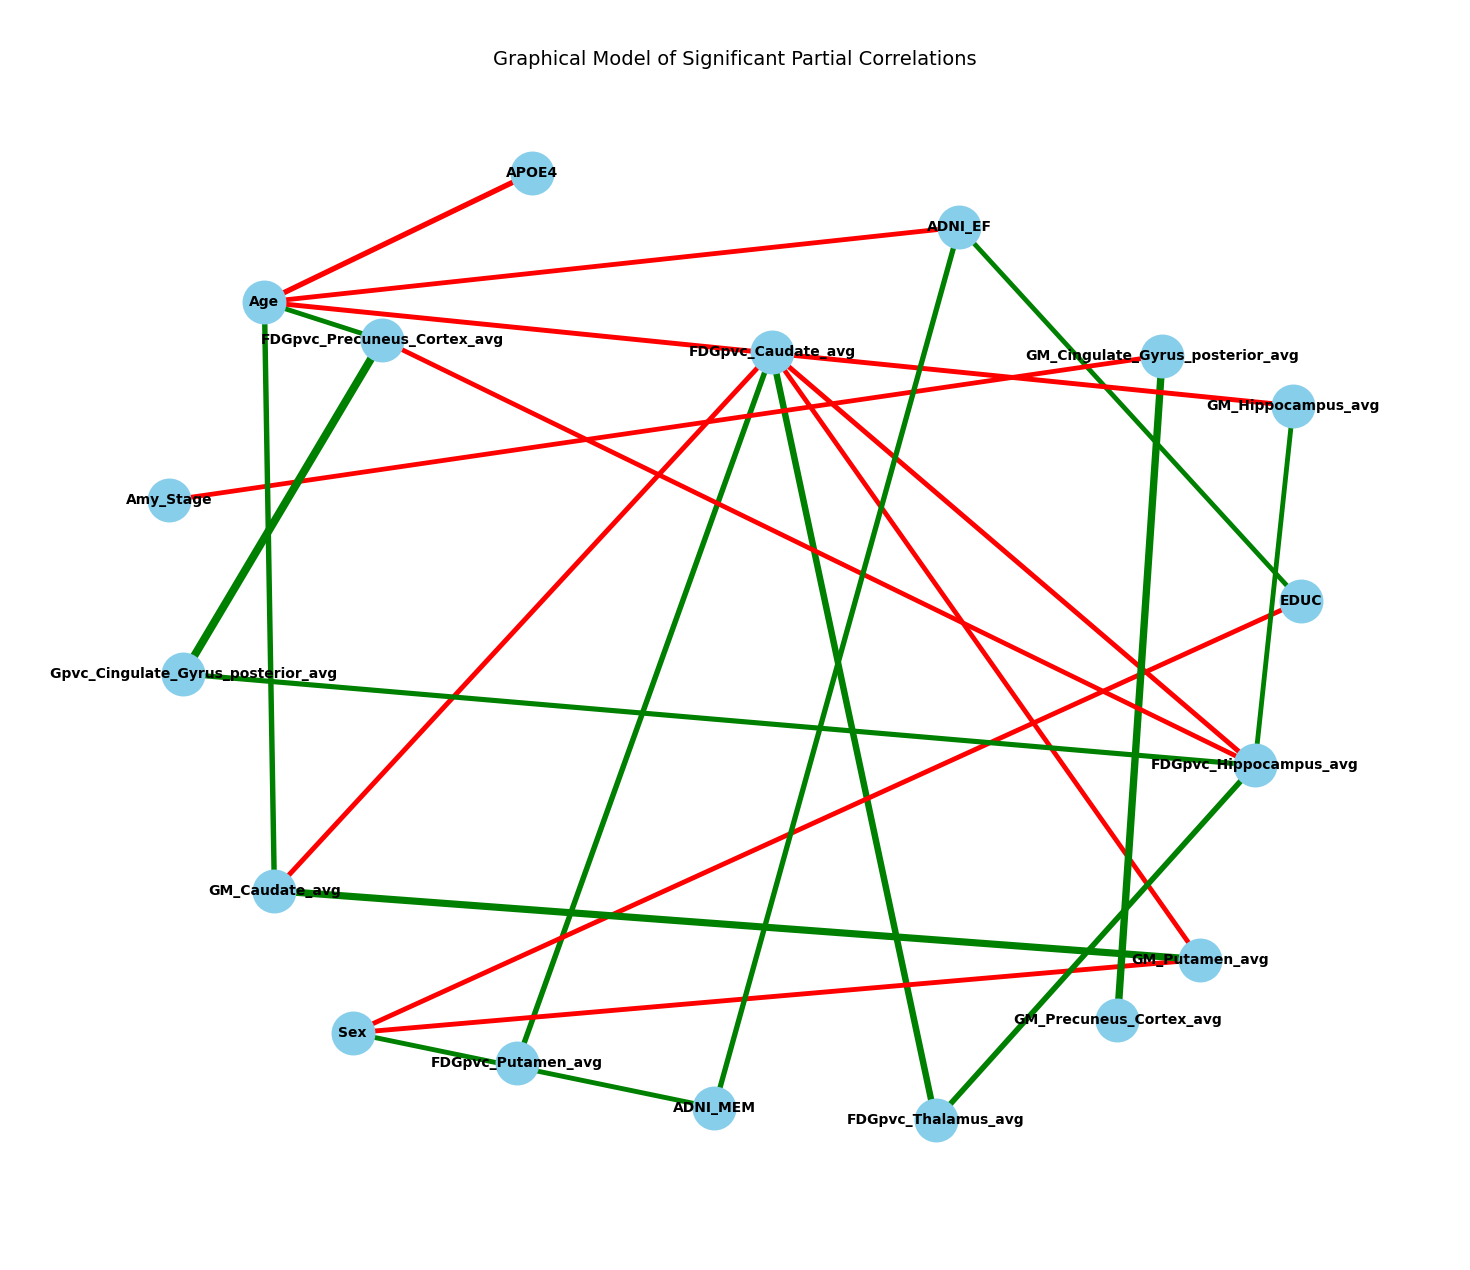

In [65]:
G = nx.Graph()
G.add_nodes_from(set(filtered_significant_df['Variable 1']).union(filtered_significant_df['Variable 2']))


for _, row in filtered_significant_df.iterrows():
    var1 = row['Variable 1']
    var2 = row['Variable 2']
    r = pcorr_matrix.loc[var1, var2]  
    G.add_edge(var1, var2, weight=abs(r), sign=np.sign(r))

plt.figure(figsize=(14, 12))


pos = nx.spring_layout(G, seed=42, k=1.5) 


nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')


edges = G.edges(data=True)
weights = [3 + 5 * edge[2]['weight'] for edge in edges] 
colors = ['red' if edge[2]['sign'] < 0 else 'green' for edge in edges]

nx.draw_networkx_edges(G, pos, width=weights, edge_color=colors)

plt.title("Graphical Model of Significant Partial Correlations", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()
plt.show()

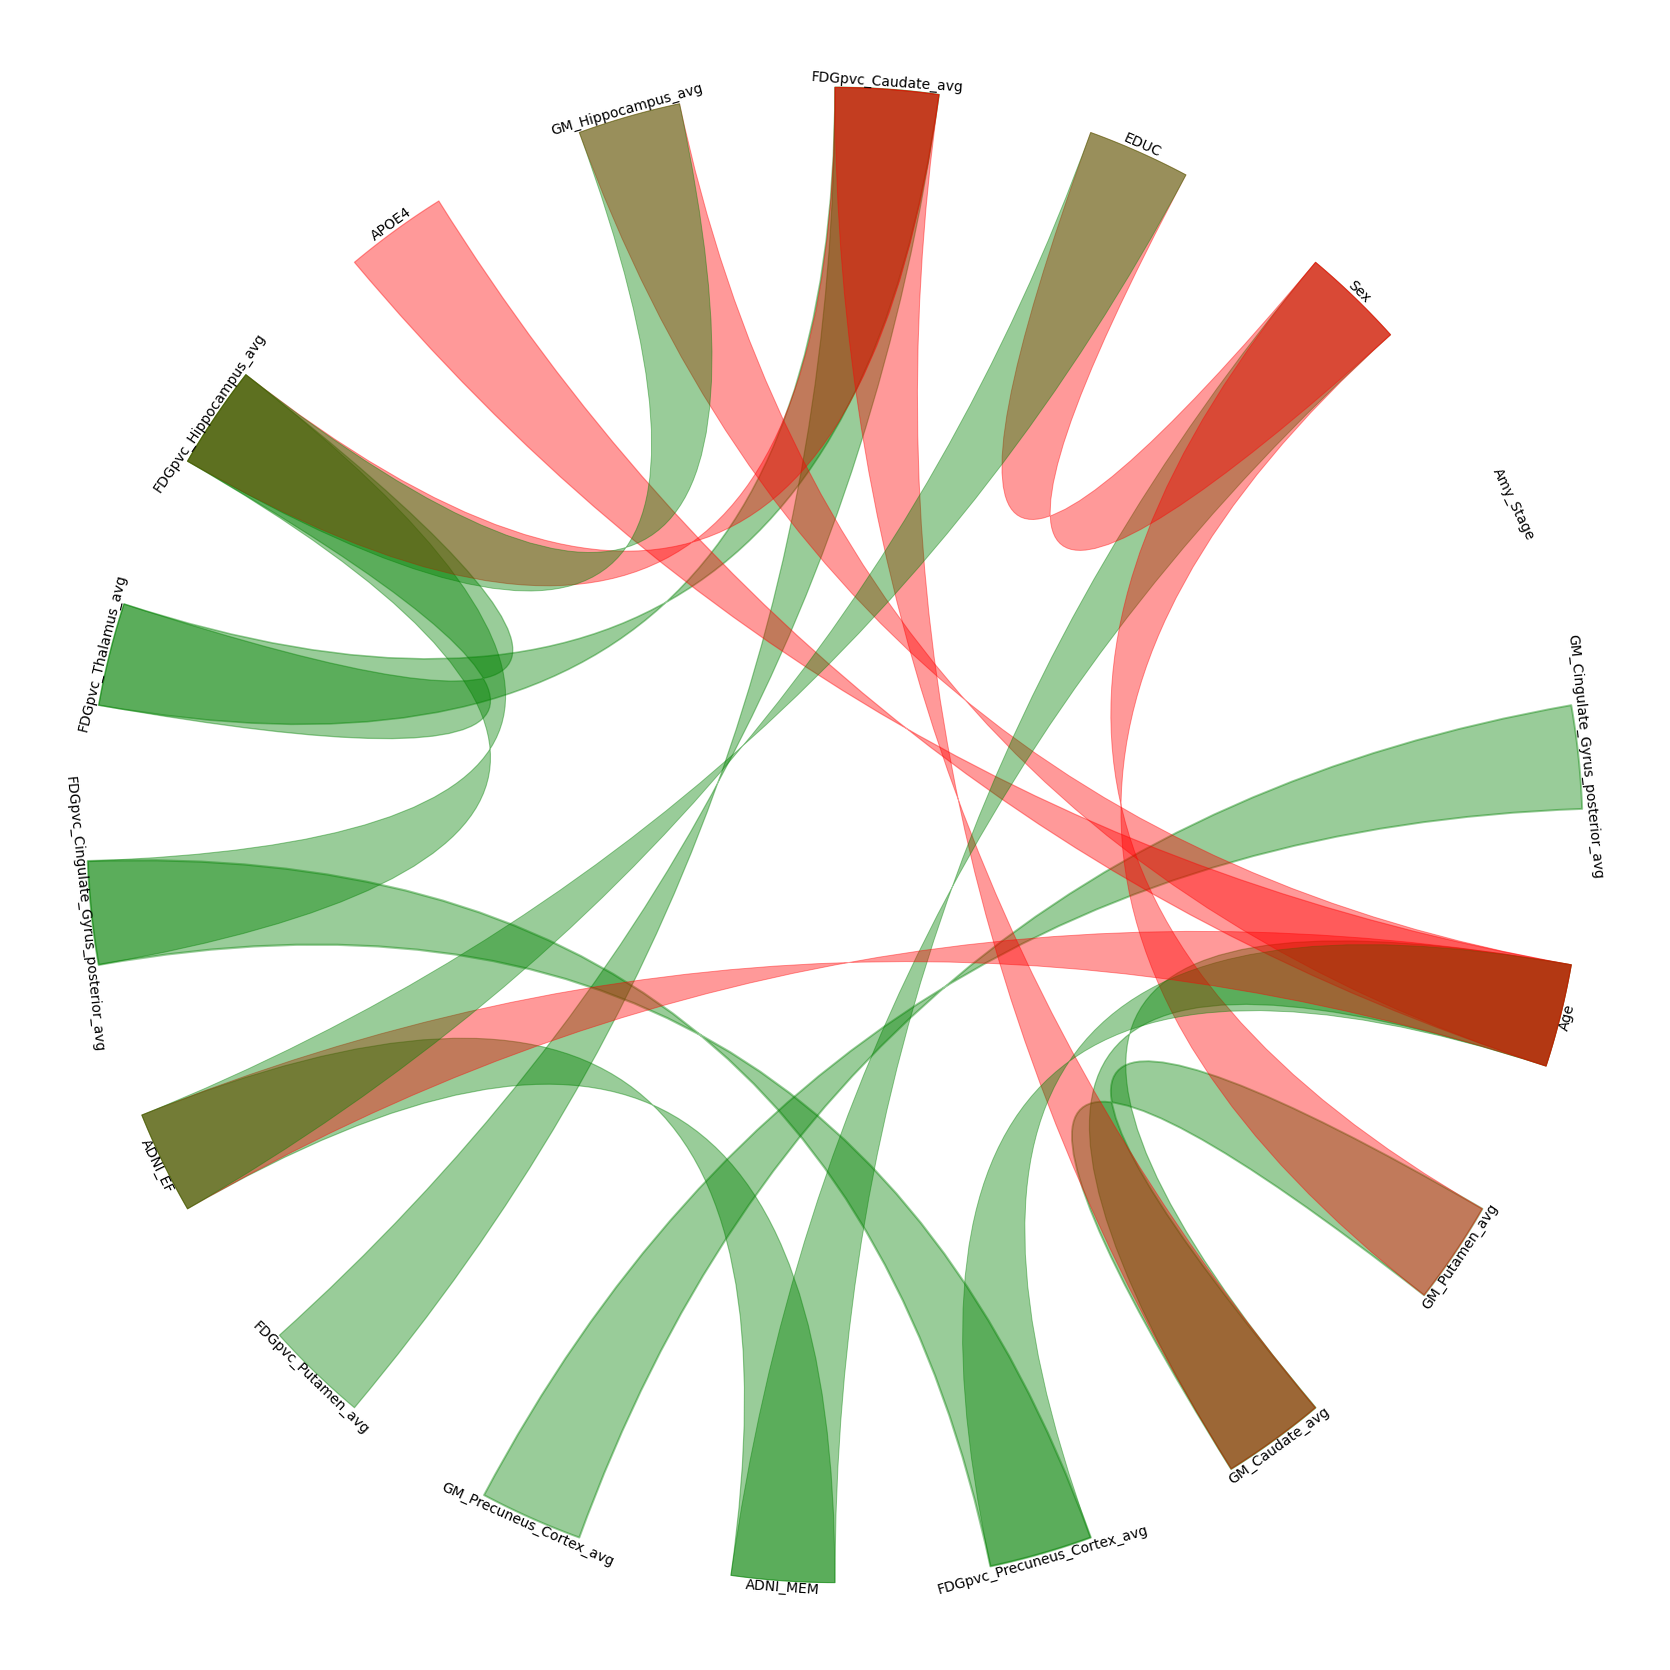

In [66]:
nodes = list(set(filtered_significant_df['Variable 1']).union(filtered_significant_df['Variable 2']))

sectors = {node: (0, 1) for node in nodes}

circos = Circos(sectors, space=12, start=0, end=360)

for sector in circos.sectors:
    sector.text(sector.name, r=100, size=10, ha='center', va='center', rotation='tangential', color='black')

top_n = 20
filtered_significant_df['abs_r'] = filtered_significant_df.apply(lambda row: abs(pcorr_matrix.loc[row['Variable 1'], row['Variable 2']]), axis=1)
top_links = filtered_significant_df.nlargest(top_n, 'abs_r')

# Add links with thinner lines and higher transparency
for _, row in top_links.iterrows():
    var1 = row['Variable 1']
    var2 = row['Variable 2']
    r = pcorr_matrix.loc[var1, var2]
    color = 'red' if np.sign(r) < 0 else 'green'
    width = 0.5 + 2 * abs(r)
    circos.link((var1, 0, 1), (var2, 0, 1), color=color, linewidth=width, alpha=0.4)

# Plot the circular graph
fig = circos.plotfig()
fig.set_size_inches(16, 16)
plt.show()

In [67]:
# q_check = significant_df1[:10]
# significant_df1.head(100)

In [68]:
# # Prepare sector names
# nodes = list(set(q_check['Variable 1']).union(q_check['Variable 2']))

# # Assign dummy ranges to each sector
# sectors = {node: (0, 1) for node in nodes}

# # Initialize Circos with larger gap and spacing
# circos = Circos(sectors, space=12, start=0, end=360)

# # Add sector labels with larger radius and tangential rotation
# for sector in circos.sectors:
#     sector.text(sector.name, r=100, size=10, ha='center', va='center', rotation='tangential', color='black')

# # Filter: keep only top N strongest absolute partial correlations
# top_n = 20
# q_check['abs_r'] = q_check.apply(lambda row: abs(pcorr_matrix.loc[row['Variable 1'], row['Variable 2']]), axis=1)
# top_links = q_check.nlargest(top_n, 'abs_r')

# # Add links with thinner lines and higher transparency
# for _, row in top_links.iterrows():
#     var1 = row['Variable 1']
#     var2 = row['Variable 2']
#     r = pcorr_matrix.loc[var1, var2]
#     color = 'red' if np.sign(r) < 0 else 'green'
#     width = 0.5 + 2 * abs(r)
#     circos.link((var1, 0, 1), (var2, 0, 1), color=color, linewidth=width, alpha=0.4)

# # Plot the circular graph
# fig = circos.plotfig()
# fig.set_size_inches(16, 16)
# plt.show()

### Composite Groups

In [70]:
df_imputed_1.shape

(1075, 192)

In [71]:
df = df_imputed_1


composite_groups = {
    'Age': ['Age'],
    'Sex': ['Sex'],
    'EDUC': ['EDUC'],
    'Biomarker': ['APOE4', 'ABETA', 'TAU', 'PTAU', 'Abeta_pos', 'SUMMARYSUVR_WHOLECEREBNORM', 'SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF', 'Amy_Stage'],
    'Cognitive_Memory': ['LDELTOTAL', 'LIMMTOTAL', 'AVDEL30MIN', 'AVDELTOT', 'MMSE'],
    'Cognitive_Executive': ['TRAASCOR', 'TRABSCOR', 'TRAB-A', 'ADNI_EF'],
    'Cognitive_Language': ['BNTSPONT', 'BNTTOTAL'],
    'Imaging_GM_Frontal': [col for col in df.columns if col.startswith('GM_') and 'Frontal' in col],
    'Imaging_GM_Temporal': [col for col in df.columns if col.startswith('GM_') and 'Temporal' in col],
    'Imaging_GM_Parietal': [col for col in df.columns if col.startswith('GM_') and 'Parietal' in col],
    'Imaging_GM_Occipital': [col for col in df.columns if col.startswith('GM_') and 'Occipital' in col],
    'Imaging_AV45_Frontal': [col for col in df.columns if col.startswith('AV45pvc_') and 'Frontal' in col],
    'Imaging_AV45_Temporal': [col for col in df.columns if col.startswith('AV45pvc_') and 'Temporal' in col],
    'Imaging_FDG_Frontal': [col for col in df.columns if col.startswith('FDGpvc_') and 'Frontal' in col],
    'Imaging_FDG_Temporal': [col for col in df.columns if col.startswith('FDGpvc_') and 'Temporal' in col]
}


composite_df = pd.DataFrame()


for group_name, variables in composite_groups.items():
    if variables:
        scaler = StandardScaler()
        standardized = scaler.fit_transform(df[variables])
        composite_score = standardized.mean(axis=1)
        composite_df[f'{group_name}_Composite'] = composite_score
        print(f"{group_name}: {len(variables)} variables → 1 composite")

composite_df['Sex_Composite'] = df['Sex']


Age: 1 variables → 1 composite
Sex: 1 variables → 1 composite
EDUC: 1 variables → 1 composite
Biomarker: 8 variables → 1 composite
Cognitive_Memory: 5 variables → 1 composite
Cognitive_Executive: 4 variables → 1 composite
Cognitive_Language: 2 variables → 1 composite
Imaging_GM_Frontal: 8 variables → 1 composite
Imaging_GM_Temporal: 13 variables → 1 composite
Imaging_GM_Parietal: 2 variables → 1 composite
Imaging_GM_Occipital: 5 variables → 1 composite
Imaging_AV45_Frontal: 8 variables → 1 composite
Imaging_AV45_Temporal: 13 variables → 1 composite
Imaging_FDG_Frontal: 8 variables → 1 composite
Imaging_FDG_Temporal: 13 variables → 1 composite


In [72]:
composite_df.head()

Age_Composite  Sex_Composite  EDUC_Composite  Biomarker_Composite  \
0       0.536021            1.0        0.666497            -0.673857   
1       0.442753            0.0       -0.822302            -0.270972   
2       1.242192            1.0        0.666497             0.204043   
3       0.575993            0.0        0.666497            -0.539839   
4       2.174871            0.0        1.410896            -0.489603   

   Cognitive_Memory_Composite  Cognitive_Executive_Composite  \
0                    0.888838                      -0.310839   
1                    0.791827                      -0.392088   
2                    1.673691                      -0.382453   
3                   -1.581243                      -0.018663   
4                    0.605986                      -0.057421   

   Cognitive_Language_Composite  Imaging_GM_Frontal_Composite  \
0                      0.850484                      0.031893   
1                      0.152321                      0.082347   
2                      0.850484                     -0.828414   
3                      0.152321                     -1.340091   
4                      0.499114                     -1.489893   

   Imaging_GM_Temporal_Composite  Imaging_GM_Parietal_Composite  \
0                      -0.346971                      -0.727940   
1                       0.050949                       0.663916   
2                      -0.682899                      -1.113852   
3                      -1.029910                      -0.871466   
4                      -0.731198                      -1.233824   

   Imaging_GM_Occipital_Composite  Imaging_AV45_Frontal_Composite  \
0                       -1.314914                       -0.454552   
1                       -0.145238                       -1.064333   
2                       -1.224372                       -0.125472   
3                       -0.746748                       -1.208667   
4                       -0.839364                       -1.473415   

   Imaging_AV45_Temporal_Composite  Imaging_FDG_Frontal_Composite  \
0                        -0.615740                       0.215397   
1                        -0.883262                      -0.724031   
2                        -0.396457                      -1.101205   
3                        -1.423021                      -1.537869   
4                        -1.427628                      -0.543883   

   Imaging_FDG_Temporal_Composite  
0                       -0.058721  
1                       -0.953761  
2                       -0.849784  
3                       -1.069542  
4                       -0.018793

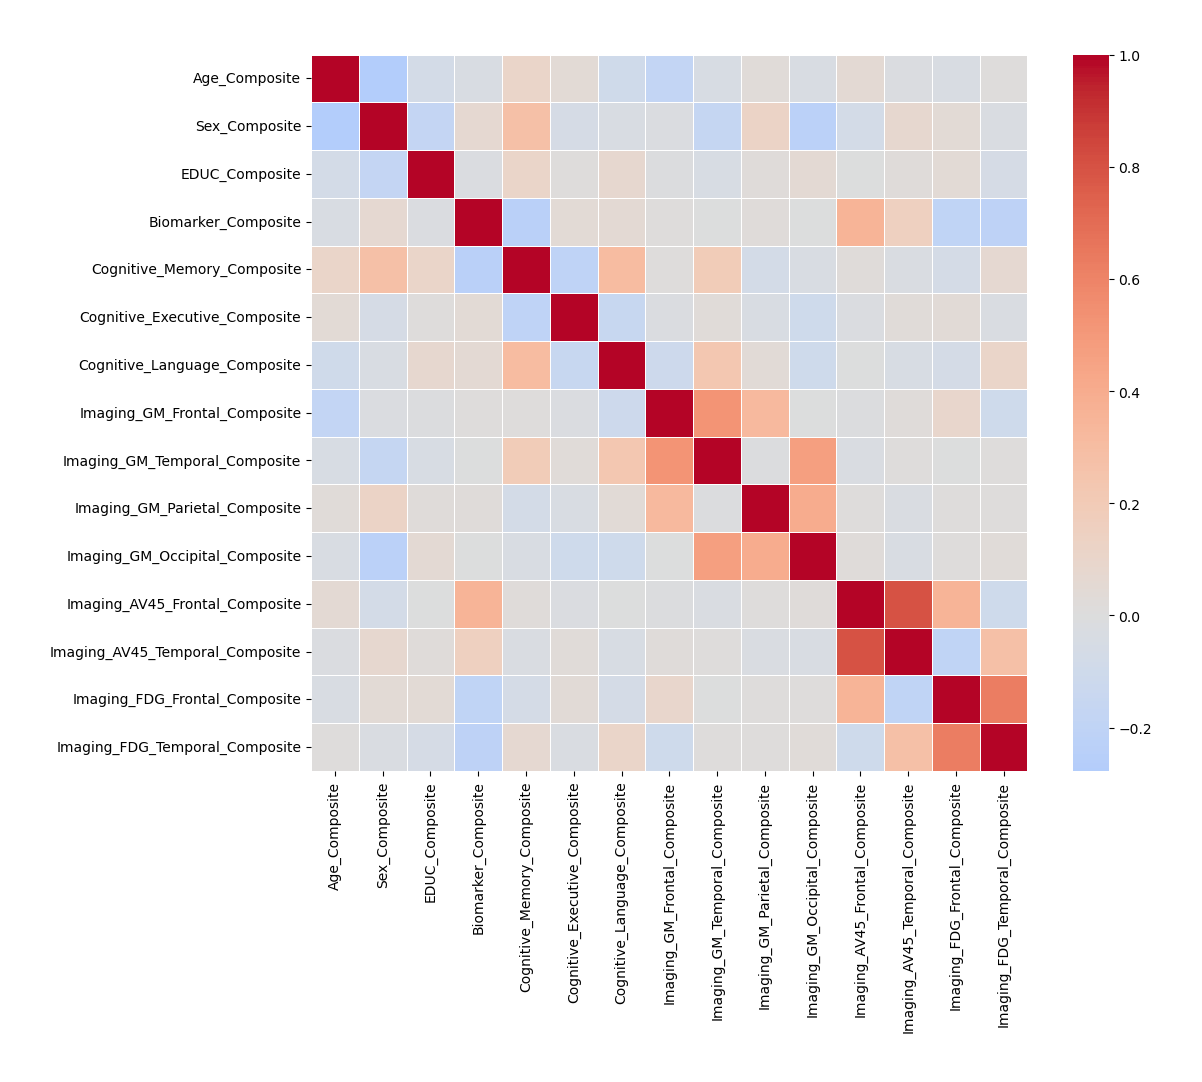

In [73]:
pcorr_matrix = pg.pcorr(composite_df)

selected_vars = composite_df.columns


pcorr_submatrix = pcorr_matrix.loc[selected_vars, selected_vars]

plt.figure(figsize=(12, 10))
sns.heatmap(pcorr_submatrix, xticklabels=selected_vars, yticklabels=selected_vars,
            cmap='coolwarm', center=0, annot=False, square=True, linewidths=0.5)
plt.tight_layout()
plt.show()

In [74]:
pcorr_matrix.to_excel("pcorr for 3rd.xlsx")

In [75]:
n = composite_df.shape[0]
variable_names = pcorr_matrix.columns
k = len(variable_names) 
df_t = n - k - 2

t_matrix = pd.DataFrame(index=variable_names, columns=variable_names, dtype=float)
p_matrix = pd.DataFrame(index=variable_names, columns=variable_names, dtype=float)

for i in range(len(variable_names)):
    for j in range(i + 1, len(variable_names)):
        var_i = variable_names[i]
        var_j = variable_names[j]
        r = pcorr_matrix.loc[var_i, var_j]

        if abs(r) == 1:
            t = np.inf
            p = 0.0
        else:
            t = r / np.sqrt((1 - r**2) / df_t)
            p = 2 * (1 - t_dist.cdf(abs(t), df_t))

        t_matrix.loc[var_i, var_j] = t
        t_matrix.loc[var_j, var_i] = t
        p_matrix.loc[var_i, var_j] = p
        p_matrix.loc[var_j, var_i] = p

In [76]:
t_matrix

Age_Composite  Sex_Composite  EDUC_Composite  \
Age_Composite                              NaN      -9.379586       -2.221808   
Sex_Composite                        -9.379586            NaN       -5.525996   
EDUC_Composite                       -2.221808      -5.525996             NaN   
Biomarker_Composite                  -0.953849       2.065946       -0.701377   
Cognitive_Memory_Composite            3.578280       9.531847        3.589506   
Cognitive_Executive_Composite         1.373779      -1.777819        0.298408   
Cognitive_Language_Composite         -3.155118      -1.148896        2.490324   
Imaging_GM_Frontal_Composite         -5.972735      -0.512860       -0.370395   
Imaging_GM_Temporal_Composite        -1.327363      -5.359239       -1.339499   
Imaging_GM_Parietal_Composite         0.959597       4.002508        0.879742   
Imaging_GM_Occipital_Composite       -0.997282      -7.625717        1.841745   
Imaging_AV45_Frontal_Composite        1.686978      -2.361021       -0.238228   
Imaging_AV45_Temporal_Composite      -0.720973       2.363683        0.672624   
Imaging_FDG_Frontal_Composite        -0.993939       1.447738        1.435342   
Imaging_FDG_Temporal_Composite        0.242148      -0.884746       -1.829257   

                                 Biomarker_Composite  \
Age_Composite                              -0.953849   
Sex_Composite                               2.065946   
EDUC_Composite                             -0.701377   
Biomarker_Composite                              NaN   
Cognitive_Memory_Composite                 -7.781901   
Cognitive_Executive_Composite               1.439121   
Cognitive_Language_Composite                1.765935   
Imaging_GM_Frontal_Composite                0.430954   
Imaging_GM_Temporal_Composite              -0.089164   
Imaging_GM_Parietal_Composite               0.824457   
Imaging_GM_Occipital_Composite             -0.074373   
Imaging_AV45_Frontal_Composite             12.306313   
Imaging_AV45_Temporal_Composite             4.860560   
Imaging_FDG_Frontal_Composite              -6.694293   
Imaging_FDG_Temporal_Composite             -6.998646   

                                 Cognitive_Memory_Composite  \
Age_Composite                                      3.578280   
Sex_Composite                                      9.531847   
EDUC_Composite                                     3.589506   
Biomarker_Composite                               -7.781901   
Cognitive_Memory_Composite                              NaN   
Cognitive_Executive_Composite                     -6.845226   
Cognitive_Language_Composite                      10.499547   
Imaging_GM_Frontal_Composite                       0.279073   
Imaging_GM_Temporal_Composite                      6.284202   
Imaging_GM_Parietal_Composite                     -2.225281   
Imaging_GM_Occipital_Composite                    -0.955884   
Imaging_AV45_Frontal_Composite                     0.686422   
Imaging_AV45_Temporal_Composite                   -0.855224   
Imaging_FDG_Frontal_Composite                     -2.143237   
Imaging_FDG_Temporal_Composite                     2.188729   

                                 Cognitive_Executive_Composite  \
Age_Composite                                         1.373779   
Sex_Composite                                        -1.777819   
EDUC_Composite                                        0.298408   
Biomarker_Composite                                   1.439121   
Cognitive_Memory_Composite                           -6.845226   
Cognitive_Executive_Composite                              NaN   
Cognitive_Language_Composite                         -4.934934   
Imaging_GM_Frontal_Composite                         -0.683594   
Imaging_GM_Temporal_Composite                         1.035369   
Imaging_GM_Parietal_Composite                        -1.040819   
Imaging_GM_Occipital_Composite                       -3.340310   
Imaging_AV45_Frontal_Composite        

In [77]:
t_matrix.to_excel("t matrix for 3.xlsx")
p_matrix.to_excel("p matrix for 3.xlsx")

In [78]:
pvals = []
pairs = []

for i in range(len(variable_names)):
    for j in range(i + 1, len(variable_names)):
        var_i = variable_names[i]
        var_j = variable_names[j]
        p = p_matrix.loc[var_i, var_j]
        pvals.append(p)
        pairs.append((var_i, var_j))


reject, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')


significant_pairs = [(pair[0], pair[1], pval_corr)
                     for pair, keep, pval_corr in zip(pairs, reject, pvals_corrected) if keep]


significant_df = pd.DataFrame(significant_pairs, columns=['Variable 1', 'Variable 2', 'Corrected p-value'])
significant_df.sort_values('Corrected p-value', inplace=True)

print(significant_df.shape)
significant_df.head()

(39, 3)


Variable 1                       Variable 2  \
0                    Age_Composite                    Sex_Composite   
34  Imaging_AV45_Frontal_Composite    Imaging_FDG_Frontal_Composite   
33  Imaging_AV45_Frontal_Composite  Imaging_AV45_Temporal_Composite   
32   Imaging_GM_Parietal_Composite   Imaging_GM_Occipital_Composite   
31   Imaging_GM_Temporal_Composite   Imaging_GM_Occipital_Composite   

    Corrected p-value  
0                 0.0  
34                0.0  
33                0.0  
32                0.0  
31                0.0

In [79]:
significant_df.to_excel("sig3_df.xlsx")

C:\Users\aleksander\AppData\Local\Temp\ipykernel_7300\4271569293.py:25: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=weights, edge_color=colors)


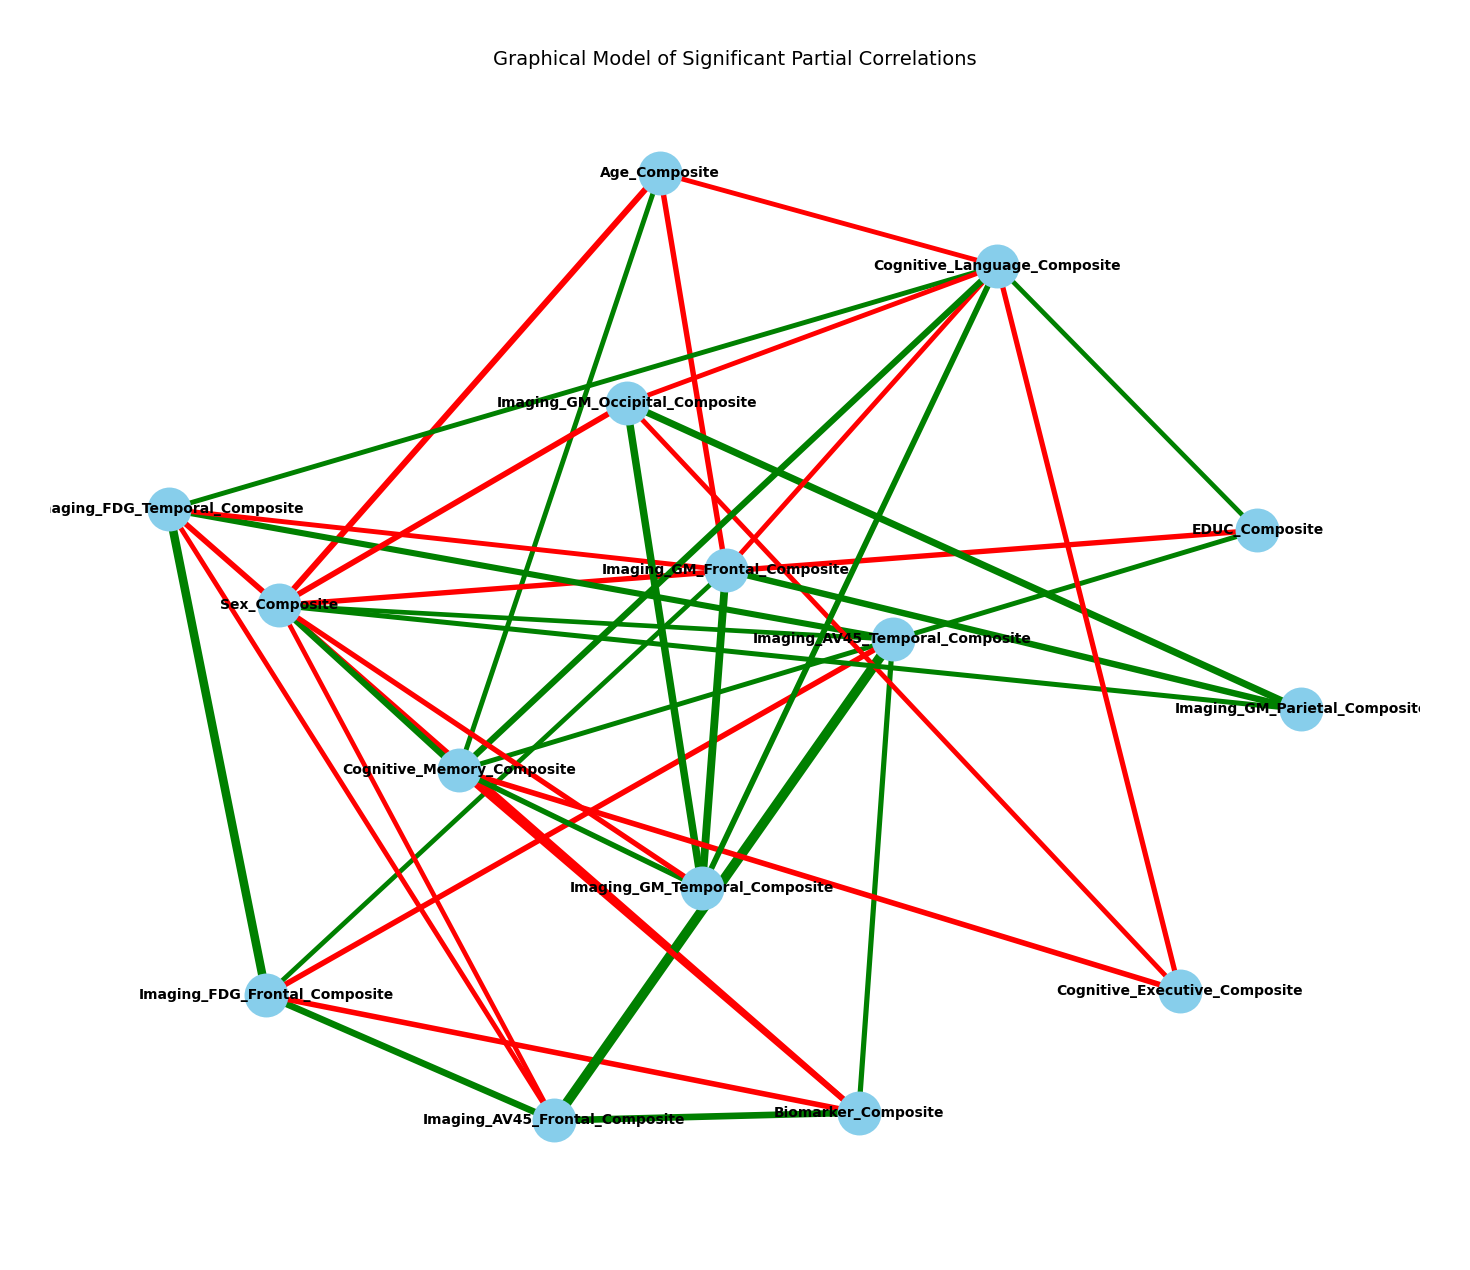

In [80]:
G = nx.Graph()
G.add_nodes_from(set(significant_df['Variable 1']).union(significant_df['Variable 2']))

# Step 2: Add edges with signed weights from partial correlation matrix
for _, row in significant_df.iterrows():
    var1 = row['Variable 1']
    var2 = row['Variable 2']
    r = pcorr_matrix.loc[var1, var2]  # signed partial correlation
    G.add_edge(var1, var2, weight=abs(r), sign=np.sign(r))

plt.figure(figsize=(14, 12))

# Try a spaced-out layou
pos = nx.spring_layout(G, seed=42, k=1.5)  

# Node drawing
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Edge styling
edges = G.edges(data=True)
weights = [3 + 5 * edge[2]['weight'] for edge in edges]  # thickness
colors = ['red' if edge[2]['sign'] < 0 else 'green' for edge in edges]

nx.draw_networkx_edges(G, pos, width=weights, edge_color=colors)

plt.title("Graphical Model of Significant Partial Correlations", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()
plt.show()

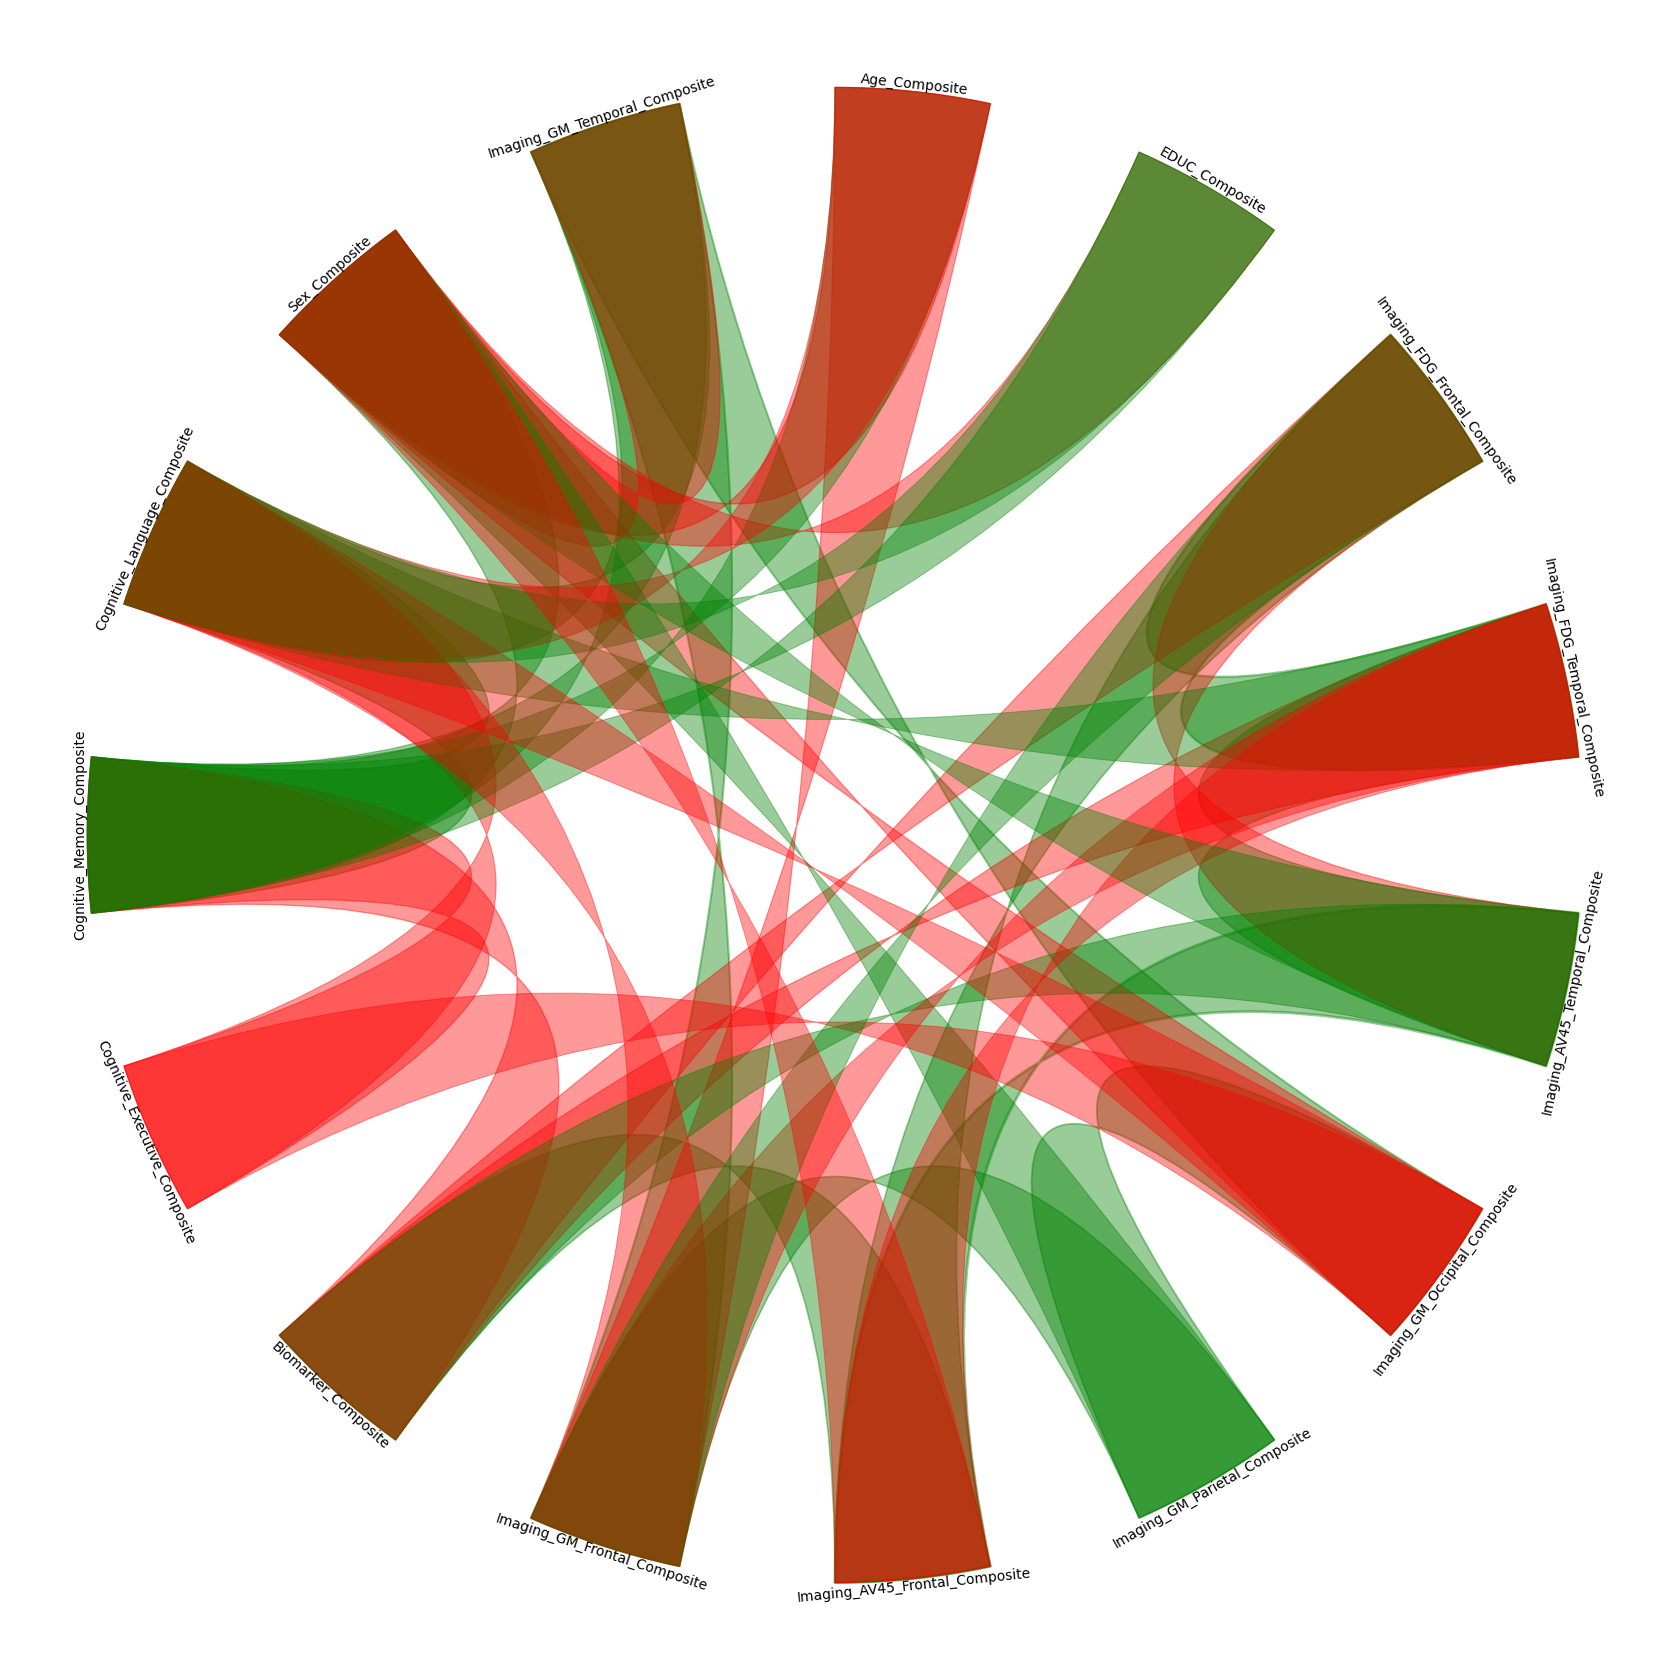

In [81]:
# Prepare sector names
nodes = list(set(significant_df['Variable 1']).union(significant_df['Variable 2']))

# Assign dummy ranges to each sector
sectors = {node: (0, 1) for node in nodes}

# Initialize Circos with larger gap and spacing
circos = Circos(sectors, space=12, start=0, end=360)

# Add sector labels with larger radius and tangential rotation
for sector in circos.sectors:
    sector.text(sector.name, r=100, size=10, ha='center', va='center', rotation='tangential', color='black')

# Filter: keep only top N strongest absolute partial correlations
top_n = 100
significant_df['abs_r'] = significant_df.apply(lambda row: abs(pcorr_matrix.loc[row['Variable 1'], row['Variable 2']]), axis=1)
top_links = significant_df.nlargest(top_n, 'abs_r')

# Add links with thinner lines and higher transparency
for _, row in top_links.iterrows():
    var1 = row['Variable 1']
    var2 = row['Variable 2']
    r = pcorr_matrix.loc[var1, var2]
    color = 'red' if np.sign(r) < 0 else 'green'
    width = 0.5 + 2 * abs(r)
    circos.link((var1, 0, 1), (var2, 0, 1), color=color, linewidth=width, alpha=0.4)

# Plot the circular graph
fig = circos.plotfig()
fig.set_size_inches(16, 16)
plt.show()